# Home Credit Default Risk (HCDR)

The course project is based on the [Home Credit Default Risk (HCDR)  Kaggle Competition](https://www.kaggle.com/c/home-credit-default-risk/). The goal of this project is to predict whether or not a client will repay a loan. In order to make sure that people who struggle to get loans due to insufficient or non-existent credit histories have a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.


## Some of the challenges

1. Dataset size 
   * (688 meg uncompressed) with millions of rows of data
   * 2.71 Gig of data uncompressed
* Dealing with missing data
* Imbalanced datasets
* Summarizing transaction data


# Kaggle API setup
Kaggle is a Data Science Competition Platform which shares a lot of datasets. In the past, it was troublesome to submit your result as your have to go through the console in your browser and drag your files there. Now you can interact with Kaggle via the command line. E.g., 

```bash
! kaggle competitions files home-credit-default-risk
```

It is quite easy to setup, it takes me less than 15 minutes to finish a submission.

1. Install library
* Create a API Token (edit your profile on [Kaggle.com](https://www.kaggle.com/)); this produces `kaggle.json` file
* Put your JSON `kaggle.json` in the right place
* Access competition files; make submissions via the command (see examples below)
* Submit result

For more detailed information on setting the Kaggle API see [here](https://medium.com/@nokkk/make-your-kaggle-submissions-with-kaggle-official-api-f49093c04f8a) and [here](https://github.com/Kaggle/kaggle-api).



In [ ]:
!pip install kaggle

In [ ]:
!pwd


In [ ]:
!mkdir /home/ec2-user/SageMaker/Unit-Project-Home-Credit-Default-Risk/.kaggle

In [ ]:
!cp /home/ec2-user/SageMaker/Unit-Project-Home-Credit-Default-Risk/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions files ./.kaggle

# Dataset and how to download


## Back ground Home Credit Group

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

### Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.


## Background on the dataset
Home Credit is a non-banking financial institution, founded in 1997 in the Czech Republic.

The company operates in 14 countries (including United States, Russia, Kazahstan, Belarus, China, India) and focuses on lending primarily to people with little or no credit history which will either not obtain loans or became victims of untrustworthly lenders.

Home Credit group has over 29 million customers, total assests of 21 billions Euro, over 160 millions loans, with the majority in Asia and and almost half of them in China (as of 19-05-2018).

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Data files overview
There are 7 different sources of data:

* __application_train/application_test:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.
* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_BALANCE:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

![alt](home_credit.png "Home credit")

## Downloading the files via Kaggle API

Create a base directory:

```bash
DATA_DIR = "../../../Data/home-credit-default-risk"   #same level as course repo in the data directory
```

Please download the project data files and data dictionary and unzip them using either of the following approaches:

1. Click on the `Download` button on the following [Data Webpage](https://www.kaggle.com/c/home-credit-default-risk/data) and unzip the  zip file to the `BASE_DIR`
2. If you plan to use the Kaggle API, please use the following steps.


In [ ]:
DATA_DIR = "../../../Data/home-credit-default-risk"   #same level as course repo in the data directory
#DATA_DIR = os.path.join('./ddddd/')
!mkdir $DATA_DIR

In [ ]:
!ls -l $DATA_DIR

In [ ]:
! kaggle competitions download home-credit-default-risk -p $DATA_DIR

### Imports

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import plotly
plotly.offline.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train AUC", 
                                   "Valid AUC",
                                   "Test  AUC"
                                  ])


In [ ]:
unzippingReq = False
if unzippingReq: #please modify this code 
    zip_ref = zipfile.ZipFile('application_train.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('application_test.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('bureau_balance.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('bureau.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('credit_card_balance.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('installments_payments.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('POS_CASH_balance.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('previous_application.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

## Data files overview
### Data Dictionary

As part of the data download comes a  Data Dictionary. It named `HomeCredit_columns_description.csv`

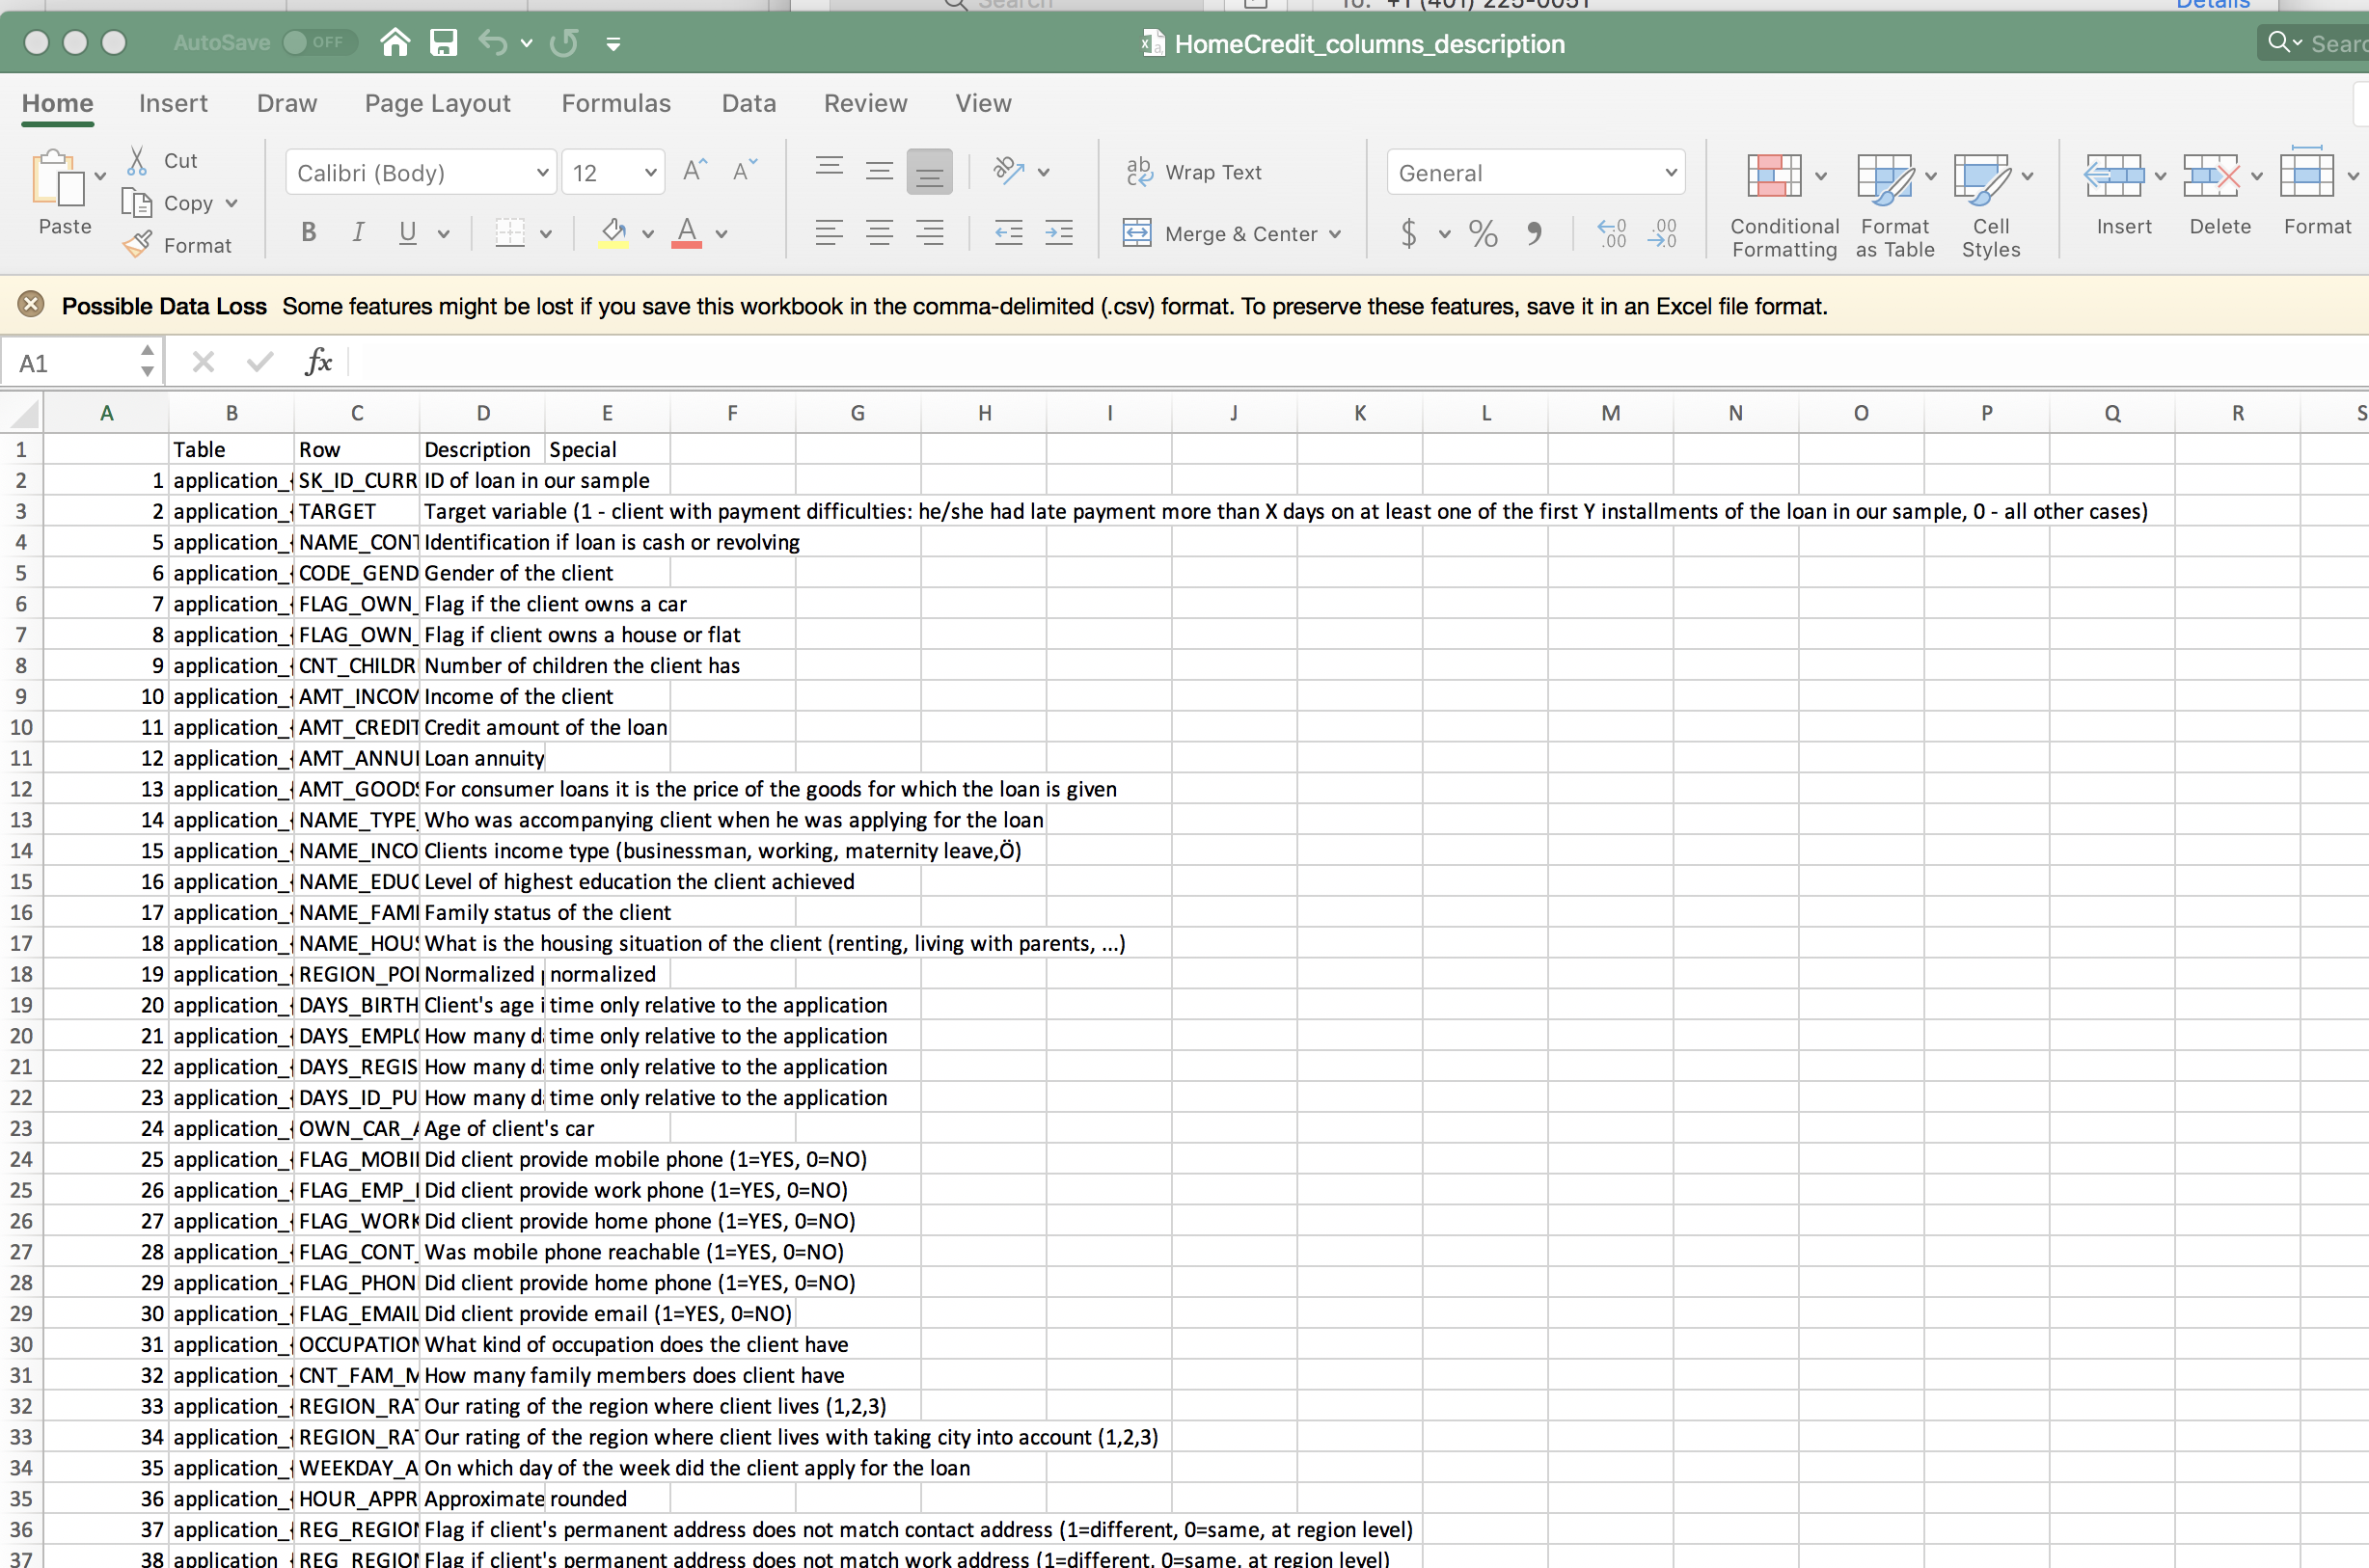

### Application train

In [3]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df
#DATA_DIR = "/home/ec2-user/SageMaker/Unit-Project-Home-Credit-Default-Risk"
DATA_DIR = '\\Users\malli\Desktop\HCDR'
datasets={}  # lets store the datasets in a dictionary so we can keep track of them easily
ds_name = 'application_train'
datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

datasets['application_train'].shape

application_train: shape is (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

(307511, 122)

### Application test


* __application_train/application_test:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.


In [5]:
ds_name = 'application_test'
datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

application_test: shape is (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

The application dataset has the most information about the client: Gender, income, family status, education ...

### The Other datasets

* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_BALANCE:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [6]:
%%time
ds_names = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
            "previous_application","POS_CASH_balance")

for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)


application_train: shape is (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

application_test: shape is (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

bureau: shape is (1716428, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

bureau_balance: shape is (27299925, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

credit_card_balance: shape is (3840312, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF          

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

installments_payments: shape is (13605401, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

previous_application: shape is (1670214, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOS

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

POS_CASH_balance: shape is (10001358, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

Wall time: 1min 14s


In [7]:
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')


dataset application_train       : [    307,511, 122]
dataset application_test        : [     48,744, 121]
dataset bureau                  : [  1,716,428, 17]
dataset bureau_balance          : [ 27,299,925, 3]
dataset credit_card_balance     : [  3,840,312, 23]
dataset installments_payments   : [ 13,605,401, 8]
dataset previous_application    : [  1,670,214, 37]
dataset POS_CASH_balance        : [ 10,001,358, 8]


# Exploratory Data Analysis

## Summary of Application Train and Application Test Datasets

In [7]:
datasets["application_train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [8]:
datasets["application_train"].describe() #numerical only features

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

In [9]:
datasets["application_train"].describe(include='all') #look at all categorical and numerical

SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER  \
count   307511.000000  307511.000000             307511      307511   
unique            NaN            NaN                  2           3   
top               NaN            NaN         Cash loans           F   
freq              NaN            NaN             278232      202448   
mean    278180.518577       0.080729                NaN         NaN   
std     102790.175348       0.272419                NaN         NaN   
min     100002.000000       0.000000                NaN         NaN   
25%     189145.500000       0.000000                NaN         NaN   
50%     278202.000000       0.000000                NaN         NaN   
75%     367142.500000       0.000000                NaN         NaN   
max     456255.000000       1.000000                NaN         NaN   

       FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count        307511          307511  307511.000000      3.075110e+05   
unique            2               2            NaN               NaN   
top               N               Y            NaN               NaN   
freq         202924          213312            NaN               NaN   
mean            NaN             NaN       0.417052      1.687979e+05   
std             NaN             NaN       0.722121      2.371231e+05   
min             NaN             NaN       0.000000      2.565000e+04   
25%             NaN             NaN       0.000000      1.125000e+05   
50%             NaN             NaN       0.000000      1.471500e+05   
75%             NaN             NaN       1.000000      2.025000e+05   
max             NaN             NaN      19.000000      1.170000e+08   

          AMT_CREDIT    AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
count   3.075110e+05  307499.000000  ...     307511.000000    307511.000000   
unique           NaN            NaN  ...               NaN              NaN   
top              NaN            NaN  ...               NaN              NaN   
freq             NaN            NaN  ...               NaN              NaN   
mean    5.990260e+05   27108.573909  ...          0.008130         0.000595   
std     4.024908e+05   14493.737315  ...          0.089798         0.024387   
min     4.500000e+04    1615.500000  ...          0.000000         0.000000   
25%     2.700000e+05   16524.000000  ...          0.000000         0.000000   
50%     5.135310e+05   24903.000000  ...          0.000000         0.000000   
75%     8.086500e+05   34596.000000  ...          0.000000         0.000000   
max     4.050000e+06  258025.500000  ...          1.000000         1.000000   

       FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
count     307511.000000    307511.000000              265992.000000   
unique              NaN              NaN                        NaN   
top                 NaN              NaN                        NaN   
freq                NaN              NaN                        NaN   
mean           0.000507         0.000335                   0.006402   
std            0.022518         0.018299                   0.083849   
min            0.000000         0.000000                   0.000000   
25%            0.000000         0.000000                   0.000000   
50%            0.000000         0.000000                   0.000000   
75%            0.000000         0.000000                   0.000000   
max            1.000000         1.000000                   4.000000   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count              265992.000000               265992.000000   
unique                       NaN                         NaN   
top                          NaN                         NaN   
freq                         NaN                         NaN   
mean                    0.007000                    0.034362   
std                     0.110757                    0.204685   
min                     0.000000           

## Missing Data for Application Train and Test

### Missing percentage and count in application train 

In [10]:
percent = (datasets["application_train"].isnull().sum()/datasets["application_train"].isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = datasets["application_train"].isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

Percent  Train Missing Count
COMMONAREA_MEDI             69.87               214865
COMMONAREA_AVG              69.87               214865
COMMONAREA_MODE             69.87               214865
NONLIVINGAPARTMENTS_MODE    69.43               213514
NONLIVINGAPARTMENTS_MEDI    69.43               213514
NONLIVINGAPARTMENTS_AVG     69.43               213514
FONDKAPREMONT_MODE          68.39               210295
LIVINGAPARTMENTS_MEDI       68.35               210199
LIVINGAPARTMENTS_MODE       68.35               210199
LIVINGAPARTMENTS_AVG        68.35               210199
FLOORSMIN_MEDI              67.85               208642
FLOORSMIN_MODE              67.85               208642
FLOORSMIN_AVG               67.85               208642
YEARS_BUILD_MEDI            66.50               204488
YEARS_BUILD_AVG             66.50               204488
YEARS_BUILD_MODE            66.50               204488
OWN_CAR_AGE                 65.99               202929
LANDAREA_MODE               59.38               182590
LANDAREA_AVG                59.38               182590
LANDAREA_MEDI               59.38               182590

### Missing percentage and count in application test

In [11]:
percent = (datasets["application_test"].isnull().sum()/datasets["application_test"].isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = datasets["application_test"].isna().sum().sort_values(ascending = False)
missing_application_test_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Test Missing Count"])
missing_application_test_data.head(20)


Percent  Test Missing Count
COMMONAREA_MEDI             68.72               33495
COMMONAREA_AVG              68.72               33495
COMMONAREA_MODE             68.72               33495
NONLIVINGAPARTMENTS_MODE    68.41               33347
NONLIVINGAPARTMENTS_MEDI    68.41               33347
NONLIVINGAPARTMENTS_AVG     68.41               33347
FONDKAPREMONT_MODE          67.28               32797
LIVINGAPARTMENTS_AVG        67.25               32780
LIVINGAPARTMENTS_MEDI       67.25               32780
LIVINGAPARTMENTS_MODE       67.25               32780
FLOORSMIN_MEDI              66.61               32466
FLOORSMIN_MODE              66.61               32466
FLOORSMIN_AVG               66.61               32466
OWN_CAR_AGE                 66.29               32312
YEARS_BUILD_MEDI            65.28               31818
YEARS_BUILD_MODE            65.28               31818
YEARS_BUILD_AVG             65.28               31818
LANDAREA_AVG                57.96               28254
LANDAREA_MODE               57.96               28254
LANDAREA_MEDI               57.96               28254

### Proportion of missing values for columns with more than 40% data missing, across all datasets

In [12]:
for data_name in ds_names:
    print ("\033[1mFeatures with more than 40% missing values in \033[94m"+str(data_name)+" dataset \033[0m \n")
    print ("\033[1mFeatures"+ (29-len("Features"))*" "+"Missing proportion"'\033[0m')
    for name in datasets[data_name].columns:
        missing_proportion=datasets[data_name][str(name)].isna().sum()/datasets[data_name].shape[0]*100
        if missing_proportion > 40:
            print (" "+str(name)+":"+ (29-len(str(name)))*" "   +"\033[91m%"+str(np.round(missing_proportion,1)),'\033[0m')
    print()

Features with more than 40% missing values in application_train dataset  

Features                     Missing proportion
 OWN_CAR_AGE:                  %66.0 
 EXT_SOURCE_1:                 %56.4 
 APARTMENTS_AVG:               %50.7 
 BASEMENTAREA_AVG:             %58.5 
 YEARS_BEGINEXPLUATATION_AVG:  %48.8 
 YEARS_BUILD_AVG:              %66.5 
 COMMONAREA_AVG:               %69.9 
 ELEVATORS_AVG:                %53.3 
 ENTRANCES_AVG:                %50.3 
 FLOORSMAX_AVG:                %49.8 
 FLOORSMIN_AVG:                %67.8 
 LANDAREA_AVG:                 %59.4 
 LIVINGAPARTMENTS_AVG:         %68.4 
 LIVINGAREA_AVG:               %50.2 
 NONLIVINGAPARTMENTS_AVG:      %69.4 
 NONLIVINGAREA_AVG:            %55.2 
 APARTMENTS_MODE:              %50.7 
 BASEMENTAREA_MODE:            %58.5 
 YEARS_BEGINEXPLUATATION_MODE: %48.8 
 YEARS_BUILD_MODE:             %66.5 
 COMMONAREA_MODE:              %69.9 
 ELEVATORS_MODE:               %53.3 
 ENTRANCES_MODE:               %50.3 
 FL

### Number of columns with missing data more or equal to 40% in application train

In [ ]:
missing_application_train_data[missing_application_train_data['Percent'] >= 40].count()

### Number of columns with missing data more or equal to 40% in application test

In [ ]:
missing_application_test_data[missing_application_test_data['Percent'] >= 40].count()

## Breakdown of primary table feature datatypes

In [13]:
datasets["application_train"].dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### Categorical Features

In [14]:
cat_features = datasets["application_train"].select_dtypes('object').columns.tolist()
cat_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

### Number of unique values for categorical features

In [15]:
datasets["application_train"].select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Value counts of categorical features

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(21, 21))
fig.subplots_adjust(hspace = .5, wspace=.51)
for c, v in enumerate(cat_features):
    ax = fig.add_subplot(4, 4, c+1)
    sns.countplot(x=v, data=datasets["application_train"])
    plt.xticks(rotation = 45)
    plt.xlabel(v)

### Numerical Features

In [ ]:
num_features = datasets["application_train"].select_dtypes(include=['float64', 'int']).columns.tolist()
num_features

## Distribution of the target column 

In [16]:
datasets["application_train"]['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

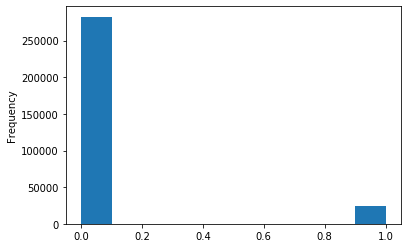

In [17]:
datasets["application_train"]['TARGET'].astype(int).plot.hist();

* If both levels of target feature are more than 10%, logistic regression classifier would be an overestimate the coefficients. Let's look at the proportions of target variable

In [18]:
print ("Percentage of target levels:")
print (np.round(datasets["application_train"]['TARGET'].value_counts()/datasets["application_train"].shape[0]*100),1)

Percentage of target levels:
0    92.0
1     8.0
Name: TARGET, dtype: float64 1


Only __8%__ of clients failed to repay on time. We have much more loans that repaid on time other than the not repaid on time. So, we have a inbalanced target distribution. 

## Correlation with  the target column 

In [ ]:
correlations = datasets["application_train"].corr(method="spearman")['TARGET'].sort_values(ascending=False)
print('Most Positive Correlations:\n', correlations.head(10))
print('\nMost Negative Correlations:\n', correlations.tail(10).sort_values(ascending=True))

From the correlations, we can see that DAYS_BIRTH which indicating the age of the client is most positively correlated with Target, and EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 are most negtively correlated with Target. we will look more close into those columns and some more column which we think might be important factors for our model. 

In [ ]:
print ('\033[1m\033[4mCorrelation Heatmap\033[0m'.center(2))

corr_heatmap=correlations.iloc[np.r_[-5:0,0:5]]
corr=pd.DataFrame(corr_heatmap).T.drop(columns="TARGET")

grid_kws = {"height_ratios": (.95, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(corr, ax=ax,
                  cbar_ax=cbar_ax,vmin=-0.2, vmax=0.1, center=0,
                  cbar_kws={"orientation": "horizontal"},square=True,
                 cmap=sns.diverging_palette(20, 220, n=200),fmt = '')

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=30,
    horizontalalignment='right'
);

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    horizontalalignment='right'
);



figure = ax.get_figure()    
figure.savefig('ax.png', dpi=900)

## Examining number of days employed of clients

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]), <a list of 10 Text xticklabel objects>)

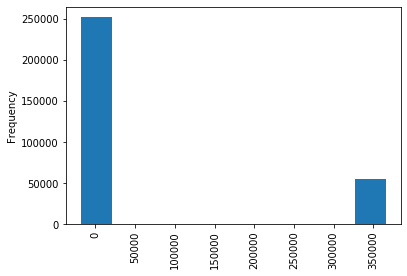

In [19]:
datasets["application_train"]['DAYS_EMPLOYED'].plot.hist();
plt.xticks(rotation='vertical')

From the above distribution, we can see that there is anomalous data present in the **DAYS_EMPLOYED** column. We need to replace these with np.nan and impute them later

## Examining statistics by Gender

In [20]:
# proportion of participants by gender
datasets["application_train"]['CODE_GENDER'].value_counts()/datasets["application_train"].shape[0]

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

In [21]:
dummies=pd.get_dummies(datasets["application_train"]['CODE_GENDER'])
target=datasets["application_train"]['TARGET']
merged= pd.concat([dummies,target],axis="columns").drop(columns=["M"])
merged=merged.rename(columns={"F": "Gender: 0=Male, 1=Female"})
merged.head(5)

Gender: 0=Male, 1=Female  XNA  TARGET
0                         0    0       1
1                         1    0       0
2                         0    0       0
3                         1    0       0
4                         0    0       0

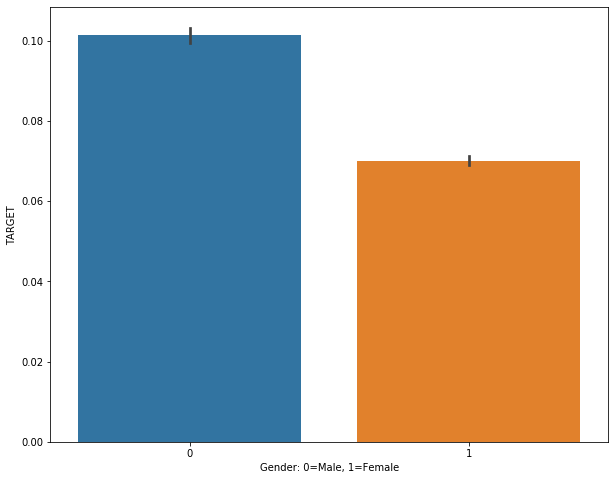

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x="Gender: 0=Male, 1=Female", y="TARGET", data=merged)

* Barplot suggests that female clients more frequently repay their loans, compared to male clients

## Examining statistics by Age of Clients 

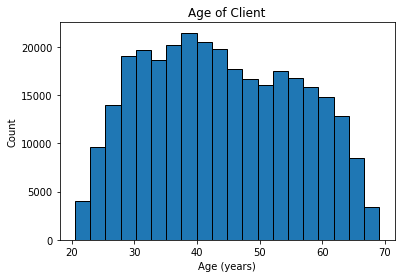

In [23]:
plt.hist(datasets["application_train"]['DAYS_BIRTH'] / -365, edgecolor = 'k', bins ="sturges")
# Plot the distribution of ages in years
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

From the histigram, we can see there are all resonable age values and no outliers. With less clients under about 25 years old and above 65 years old, we have more applicants between 25 years old to 45 years old. But we can't tell much how age will influent the target value. Let's plot the density plots to show the distribution of applicants' age with different target values.   

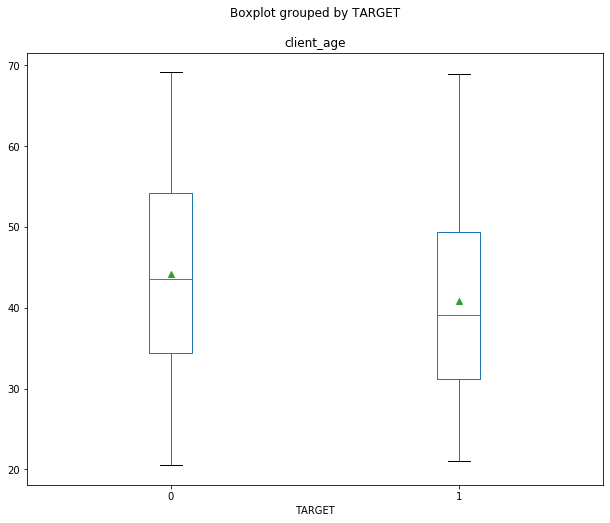

In [24]:
datasets["application_train"]["client_age"]= -datasets["application_train"][['DAYS_BIRTH']]/365
fig, ax = plt.subplots(figsize=(10,8))

datasets["application_train"].boxplot(column=['client_age'], by='TARGET', ax=ax,grid=False, 
                                      showmeans =True )


The above boxplot indicates that older clients tend to repay the loans more frequently compared to younger clients

## Density Plots for External Sources 

From the density plots, we can see older clients have better records about repaid loans. 

External scource is about "normalized score from external data source". The density plots of these external sources shows how they related with the target value. EXT_SOURCE_1 and EXT_SOURCE_3 show less score related higher failure in repaying loans. EXT_SOURCE_2 does not show obvious difference but it agrees with lower score pointing to high failure rate.

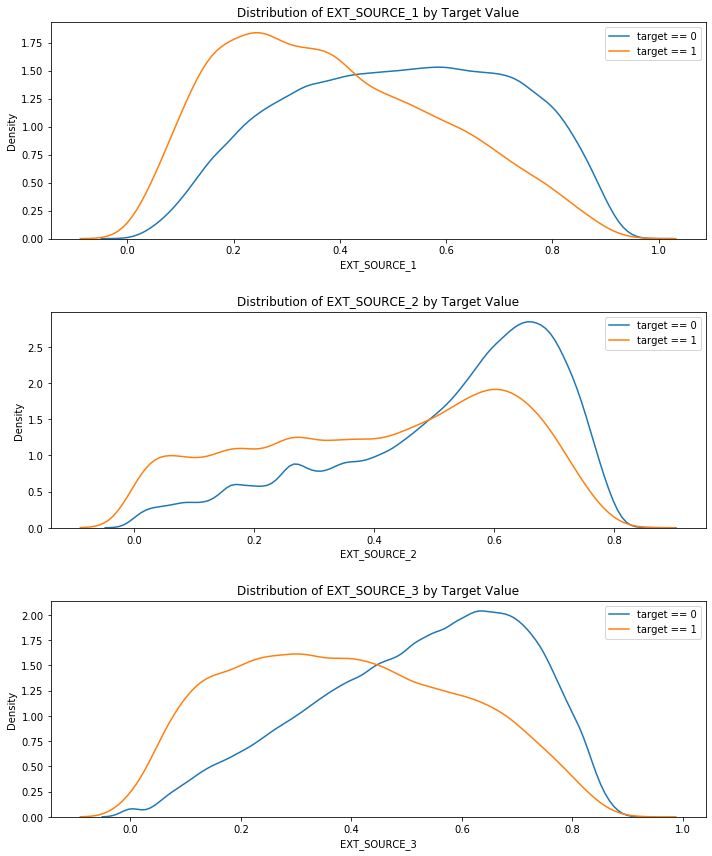

In [25]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(datasets["application_train"].loc[datasets["application_train"]['TARGET'] == 0, source].dropna(), label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(datasets["application_train"].loc[datasets["application_train"]['TARGET'] == 1, source].dropna(), label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

## Input variables Correlation Test

* Correlation between AMT_ANNUITY and AMT_CREDIT

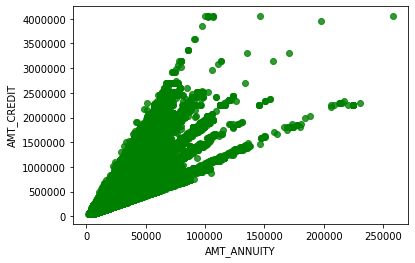

In [26]:
sns.regplot(datasets["application_train"]['AMT_ANNUITY'], datasets["application_train"]['AMT_CREDIT'], color="g", fit_reg=False)


From the above plot, the variables AMT_ANUITY and AMT_CREDIT seem to be postively correlated. One of features can be excluded from the final list of input features

## Dataset questions
* Unique record for each SK_ID_CURR

In [ ]:
datasets.keys()

In [ ]:
len(datasets["application_train"]["SK_ID_CURR"].unique()) == datasets["application_train"].shape[0]

In [ ]:
#Return the sorted, unique values that are in both of the input arrays.
np.intersect1d(datasets["application_train"]["SK_ID_CURR"], datasets["application_test"]["SK_ID_CURR"])

## EDA on secondary table processing

1. Transform all the secondary tables to features that can be joined into the main table the application table (labeled and unlabeled)
   * 'bureau', 'bureau_balance', 'credit_card_balance', 'installments_payments', 
   * 'previous_application', 'POS_CASH_balance'
* Merge the transformed secondary tables with the primary tables (i.e., the `application_train` data (the labeled dataset) and with the `application_test` data (the unlabeled submission dataset)), thereby leading to X_train, y_train, X_valid, etc.
* Proceed with the learning pipeline using X_train, y_train, X_valid, etc.
* Generate a submission file using the learnt model


### Previous Application Dataset

The persons in the kaggle submission file have had previous applications in the `previous_application.csv`. 47,800 out 48,744 people have had previous appications.

In [ ]:
Pre_appsDF = datasets["previous_application"]

In [ ]:
Pre_appsDF.shape

In [ ]:
len(np.intersect1d(datasets["previous_application"]["SK_ID_CURR"], datasets["application_test"]["SK_ID_CURR"]))

* Missing values in prevApps

In [ ]:
Pre_appsDF.isna().sum()

In [ ]:
Pre_appsDF.columns

In [ ]:
print(f"There are  {Pre_appsDF.shape[0]:,} previous applications")

In [ ]:
# How many entries are there for each month?
prevAppCounts = Pre_appsDF['SK_ID_CURR'].value_counts(dropna=False)


In [ ]:
len(prevAppCounts[prevAppCounts >40])  #more than 40 previous applications

In [ ]:
prevAppCounts[prevAppCounts >50].plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

#### Histogram of Number of previous applications for an ID

In [ ]:
#what's this for?
sum(Pre_appsDF['SK_ID_CURR'].value_counts()==1)

In [ ]:
# Histogram of accumulated Number of previous applications
plt.hist(Pre_appsDF['SK_ID_CURR'].value_counts(), cumulative =True, bins = 100);
plt.grid()
plt.ylabel('cumulative number of IDs')
plt.xlabel('Number of previous applications per ID')
plt.title('Histogram of Number of previous applications for an ID')


#### Previous loan rejection reasons

In [ ]:
Pre_appsDF['CODE_REJECT_REASON'].nunique()

In [ ]:
Pre_appsDF['CODE_REJECT_REASON'].value_counts()

#### Previous loans status - Count of Approved and Rejected

In [ ]:
Pre_appsDF['NAME_CONTRACT_STATUS'].value_counts()

In [ ]:
Pre_apps_all = Pre_appsDF['SK_ID_CURR'].nunique()
Pre_apps_5plus = Pre_appsDF['SK_ID_CURR'].value_counts()>=5
Pre_apps_40plus = Pre_appsDF['SK_ID_CURR'].value_counts()>=40
print('Percentage with 10 or more previous apps:', np.round(100.*(sum(Pre_apps_5plus)/Pre_apps_all),5))
print('Percentage with 40 or more previous apps:', np.round(100.*(sum(Pre_apps_40plus)/Pre_apps_all),5))

##### **Can we differentiate applications by low, medium and high previous apps?**
    * Low = <5 claims (22%)
    * Medium = 10 to 39 claims (58%)
    * High = 40 or more claims (20%)

### Installments Payments Dataset

In [ ]:
instDF = datasets['installments_payments']

In [ ]:
sum(instDF['SK_ID_CURR'].value_counts()==1)

In [ ]:
len(np.intersect1d(datasets['installments_payments']["SK_ID_CURR"], datasets["application_train"]["SK_ID_CURR"]))

In [ ]:
instDF.head()

In [ ]:
instDF.describe()

### Credit Card balance dataset

In [169]:
ccbDF3 = datasets['credit_card_balance']

#### Number of clients on the application training data with credit card balance data

In [ ]:
len(np.intersect1d(datasets['credit_card_balance']["SK_ID_CURR"], datasets["application_train"]["SK_ID_CURR"]))

From the above, it can be seen that the credit card balance data is available only for 30% of the input training data. Imputing the missing values with mean may not be appropriate

In [ ]:
ccbDF.head()

### Bureau and Bureau Balance Datasets

In [ ]:
burDF = datasets['bureau']
burbDF = datasets['bureau_balance']

In [ ]:
burDF.head()

In [ ]:
burDF.shape

In [ ]:
print(len(np.intersect1d(burDF["SK_ID_CURR"], datasets["application_train"]["SK_ID_CURR"])))
print(round(len(np.intersect1d(burDF["SK_ID_CURR"], datasets["application_train"]["SK_ID_CURR"]))/len(np.unique(datasets["application_train"]["SK_ID_CURR"])),2))

In [ ]:
print(len(np.intersect1d(burDF["SK_ID_CURR"], datasets["application_test"]["SK_ID_CURR"])))
print(round(len(np.intersect1d(burDF["SK_ID_CURR"], datasets["application_test"]["SK_ID_CURR"]))/len(np.unique(datasets["application_test"]["SK_ID_CURR"])),2))

Looking through some of the high-level numbers in the Bureau dataset, more than 85% of our applicants have information on this dataset, so it's definitely worth pursuing adding this information into the model.

In [ ]:
burbDF.head()

In [ ]:
np.count_nonzero(burDF['CREDIT_DAY_OVERDUE'])/len(burDF['CREDIT_DAY_OVERDUE'])

Bureau Balance is a level of granularity on each credit that we do not need to be concerned with. We have only .2% of our population has overdue credits, so calculating out the number of individual months overdue isn't going to be of much benefit.

So now we will take a look at our various features and their distributions.

In [ ]:
sns.countplot(burDF['CREDIT_ACTIVE'])

We've got a health number of obsevations in both active credit. We will be comfortable engineering features off of these subsets.

In [ ]:
plt.hist(burDF['DAYS_CREDIT'],bins = 20)

# Feature Engineering

## Engineering Features: Primary table - application_train

**Deriving new features from the training data:**
 
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in years
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age (after imputing anomalous values in 'DAYS_EMPLOYED')
* GOODS_PRICE_CREDIT_PERCENT: the percentage of the goods price relative to the loan credit amount
* INCOME_PER_FAM_MEMBERS: the income per family members
* TOTAL_ENQ_BUREAU: total number of enquiries to Credit Bureau 
* RATIO_CAR_TO_BRITH: 
* RATIO_CAR_TO_EMPLOY:
* RATIO_PHONE_TO_BIRTH:
* RATIO_PHONE_TO_EMPLOY:


In [7]:
class app_add_features(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features # no *args or **kargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X=pd.DataFrame(X, columns=self.features)
        X['ANNUITY_INCOME_PERCENT'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
        X['CREDIT_TERM'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
        X['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
        X['AGE'] = X['DAYS_BIRTH'] / -365
        X['DAYS_EMPLOYED_PERCENT'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
        X['GOODS_PRICE_CREDIT_PERCENT']=X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
        X['INCOME_PER_FAM_MEMBERS']=X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
        X['TOTAL_ENQ_BUREAU']=X['AMT_REQ_CREDIT_BUREAU_DAY']\
        +X['AMT_REQ_CREDIT_BUREAU_WEEK']\
        + X['AMT_REQ_CREDIT_BUREAU_MON']\
        + X['AMT_REQ_CREDIT_BUREAU_QRT']\
        + X['AMT_REQ_CREDIT_BUREAU_YEAR']
        X['RATIO_CAR_TO_BRITH']=X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
        X['RATIO_CAR_TO_EMPLOY'] = X['OWN_CAR_AGE'] / X['DAYS_EMPLOYED']
        X['RATIO_PHONE_TO_BIRTH'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
        X['RATIO_PHONE_TO_EMPLOY'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_EMPLOYED']
        ##########
        X=X.replace([np.inf, -np.inf], np.nan)
        return X

In [ ]:
'DAYS_BIRTH','DAYS_EMPLOYED','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'

In [ ]:
'AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_EMPLOYED','DAYS_BIRTH','AMT_CREDIT','AMT_GOODS_PRICE','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'

## Engineering Features: previous_application

**New features**
* Count of previous approved applications based on NAME_CONTRACT_STATUS
* Count of previous refused applications based on NAME_CONTRACT_STATUS
* Difference between applied and approved credit amount.
* Aggregate stats for 'AMT_ANNUITY'
* Aggregate stats for 'AMT_APPLICATION'
* Prev_GOODS_PRICE_CREDIT_PERCENT: the percentage of the goods price relative to the loan credit amount
* Prev_CREDIT_APP_PERCENTAGE: the percentage of the credit was granted relative to the loan was applied
* CALC_FLAG_PRIVILEGED_CUSTOMER
* CALC_TERMINATED
* CALC_LAST_DUE_AFTER_APPL
* Group by the client id, calculate aggregation statistics

In [8]:
class prev_apps_add_features1(BaseEstimator, TransformerMixin):
    def __init__(self, feature=None): # no *args or **kargs
        self.feature = feature # no *args or **kargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X=pd.DataFrame(X)
        X['Pre_GOODS_PRICE_CREDIT_PERCENT']=X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
        X['Pre_CREDIT_APP_PERCENTAGE']=X['AMT_CREDIT'] / X['AMT_APPLICATION']
        X['CALC_FLAG_PRIVILEGED_CUSTOMER']=(X['RATE_INTEREST_PRIVILEGED']>0).astype(int)
        X['CALC_TERMINATED']=(X['DAYS_TERMINATION']<0).astype(int)
        X['CALC_LAST_DUE_AFTER_APPL']=(X['DAYS_LAST_DUE_1ST_VERSION']>0).astype(int)
        X=X.replace([np.inf, -np.inf], np.nan)
    
        return X

In [9]:
class prev_apps_add_features2(BaseEstimator, TransformerMixin):
    def __init__(self, feature='text'): # no *args or **kargs
        self.feature = feature # no *args or **kargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Prev_appr_count'] = X['NAME_CONTRACT_STATUS'].map(lambda x: 1 if (x == 'Approved') else 0)
        X['Prev_rej_count'] = X['NAME_CONTRACT_STATUS'].map(lambda x: 1 if (x == 'Refused') else 0)
        X['Diff_credit_appr'] = X['AMT_APPLICATION'] - X['AMT_CREDIT'] 
        return X

In [10]:
# Create aggregate features (via pipeline)
class prevAppsFeaturesAggregater(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
        self.agg_op_features = {}
        for f in features:
            if f not in (features[-1], features[-2]):
                self.agg_op_features[f] = {f"{f}_{func}":func for func in ["min", "max", "mean"]}
            else:
                self.agg_op_features[f] = {f"{f}_{func}":func for func in ["sum"]}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit         
        result = X.groupby(["SK_ID_CURR"]).agg(self.agg_op_features)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=["SK_ID_CURR"])
        result['range_AMT_APPLICATION'] = result['AMT_APPLICATION_max'] - result['AMT_APPLICATION_min']
        return result # return dataframe with the join key "SK_ID_CURR"
    

In [11]:
'Pre_GOODS_PRICE_CREDIT_PERCENT', 'Pre_CREDIT_APP_PERCENTAGE','Prev_appr_count','Prev_rej_count','Diff_credit_appr'

('Pre_GOODS_PRICE_CREDIT_PERCENT',
 'Pre_CREDIT_APP_PERCENTAGE',
 'Prev_appr_count',
 'Prev_rej_count',
 'Diff_credit_appr')

## Engineering Features: Installment Payments

* Percent of AMT_INSTALMENT and AMT_PAYMENT
* Percent of DAYS_ENTRY_PAYMENT and DAYS_INSTALMENT

In [12]:
class instpmts_add_features1(BaseEstimator, TransformerMixin):
    def __init__(self, feature=None): # no *args or **kargs
        self.feature = feature # no *args or **kargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Perc_amt_paid'] = X['AMT_INSTALMENT'] / X['AMT_PAYMENT'] 
        X['Perc_pmt_days'] = X['DAYS_ENTRY_PAYMENT'] / X['DAYS_INSTALMENT'] 
        X['DAYS_LATE_PAYMENT']=X['DAYS_ENTRY_PAYMENT']-X['DAYS_INSTALMENT']
        X['DIFF_INSTALMENT']=X['AMT_INSTALMENT']-X['AMT_PAYMENT']
        X['PERC_DIFF_INSTALMENT']=np.abs(X['DIFF_INSTALMENT'])/X['AMT_INSTALMENT']
        X['INSTAL_PAID_LATE'] = (X['DAYS_LATE_PAYMENT'] > 0).astype(int)
        X['OVERPAID']= (X['DIFF_INSTALMENT'] < 0).astype(int)
        X=X.replace([np.inf, -np.inf], np.nan)
        return X

In [13]:
# Create aggregate features (via pipeline)
class instpmntsFeaturesAggregater(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
        self.agg_op_features = {}
        for f in features:
            #self.agg_op_features[f] = {f"{f}_{func}":func for func in ["min", "max", "mean"]}
            self.agg_op_features[f] = {f"{f}_{func}":func for func in ["mean"]}
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit         
        result = X.groupby(["SK_ID_CURR"]).agg(self.agg_op_features)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=["SK_ID_CURR"])
        return result # return dataframe with the join key "SK_ID_CURR"

## Engineering Features: Credit Card Balance

* Credit Utilisation - AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL
* Total number of Days past Due - SK_DPD_DEF

In [14]:
class crdcardbal_add_features1(BaseEstimator, TransformerMixin):
    def __init__(self, feature='text'): # no *args or **kargs
        self.feature = feature # no *args or **kargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['MONTHS_BALANCE']=X['MONTHS_BALANCE'].abs()
        X['CALC_PERC_DRAWINGS_ATM_CURRENT']=X['AMT_DRAWINGS_ATM_CURRENT']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_DRAWINGS_CURRENT']=X['AMT_DRAWINGS_CURRENT']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_DRAWINGS_OTHER_CURRENT']=X['AMT_DRAWINGS_OTHER_CURRENT']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_DRAWINGS_POS_CURRENT']=X['AMT_DRAWINGS_POS_CURRENT']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_INST_MIN_REGULARITY']=X['AMT_INST_MIN_REGULARITY']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_PAYMENT_CURRENT']=X['AMT_PAYMENT_CURRENT']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_PAYMENT_TOTAL_CURRENT']=X['AMT_PAYMENT_TOTAL_CURRENT']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_RECEIVABLE_PRINCIPAL']=X['AMT_RECEIVABLE_PRINCIPAL']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_PERC_RECIVABLE']=X['AMT_RECIVABLE']/X['AMT_CREDIT_LIMIT_ACTUAL']
        X['CALC_DAYS_WITHOUT_TOLERANCE']=X['SK_DPD']-X['SK_DPD_DEF']

        CNT_DRAWING_LIST=['CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT','CNT_DRAWINGS_POS_CURRENT']
        X['CALC_CNT_DRAWINGS_TOTAL']=X[CNT_DRAWING_LIST].sum(axis=1)
        X=X.replace([np.inf, -np.inf], np.nan)
    
        #X['Diff_amt_paid'] = X['AMT_INSTALMENT'] - X['AMT_PAYMENT'] 
        #X['Diff_pmt_days'] = X['DAYS_ENTRY_PAYMENT'] - X['DAYS_INSTALMENT'] 
        return X

In [15]:
# Create aggregate features (via pipeline)
class crdcardbalFeaturesAggregater(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
        self.agg_op_features = {}
        for f in features:
            if f not in (features[-1], features[-2]):
                self.agg_op_features[f] = {f"{f}_{func}":func for func in ["min", "max", "mean"]}
            else:
                self.agg_op_features[f] = {f"{f}_{func}":func for func in ["sum"]}
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit         
        result = X.groupby(["SK_ID_CURR"]).agg(self.agg_op_features)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=["SK_ID_CURR"])
        #result.columns = [' '.join(col).strip() for col in result.columns.values]
        result['Perc_Credit_util'] = np.round(result['AMT_BALANCE_sum'] / result['AMT_CREDIT_LIMIT_ACTUAL_sum'],3)
        result.drop(['AMT_BALANCE_sum', 'AMT_CREDIT_LIMIT_ACTUAL_sum'], axis=1, inplace=True)
        result=result.replace([np.inf, -np.inf], np.nan)
        return result # return dataframe with the join key "SK_ID_CURR"
    
    
# from sklearn.pipeline import make_pipeline 
# def test_driver_crecardbalFeaturesAggregater(df, features):
#    print(f"df.shape: {df.shape}\n")
#    print(f"df[{features}][0:5]: \n{df[features][0:5]}")
#    test_pipeline = make_pipeline(crdcardbalFeaturesAggregater(features))
#    return(test_pipeline.fit_transform(df))
         
# card_features = ['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'SK_DPD_DEF']
# res = test_driver_crecardbalFeaturesAggregater(ccbDF3, card_features)
# print(f"HELLO")
# print(f"Test driver: \n{res[0:3]}")
# print(f"input[features][0:10]: \n{Pre_appsDF[0:3]}")


## Engineering Features: Bureau and Bureau Balance
We will engineer a few features. First, we'll get the total active credit and total debt for each consumer.  Then we will determine the most recent credit activity for each consumer.

In [16]:
class bur_add_features(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features # no *args or **kargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X,y=None):
        X['Total_Credit'] = X[X['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
        X['Total_Debt'] = X.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()
        X['Most_Recent_Days_Credit'] = X[X['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR')['DAYS_CREDIT'].max()
        X['CALC_PER_CREDIT_MAX_OVERDUE']=X['AMT_CREDIT_MAX_OVERDUE']/X['AMT_CREDIT_SUM']
        X['CALC_CREDIT_CLOSED']=(X['DAYS_ENDDATE_FACT'] < 0).astype(int)
        X['MONTHS_BALANCE']=X['MONTHS_BALANCE'].abs()
        X['PER_CREDIT_SUM_OVERDUE']=X['AMT_CREDIT_SUM_OVERDUE']/X['AMT_CREDIT_SUM']
        X=X.replace([np.inf, -np.inf], np.nan)
    
#         X['Total_Credit'].fillna(0, inplace=True)
#         X['Total_Debt'].fillna(0, inplace=True)
#         X['Most_Recent_Days_Credit'].fillna(0, inplace=True)
        return X

In [17]:
'Total_Credit','Total_Debt','Most_Recent_Days_Credit'

('Total_Credit', 'Total_Debt', 'Most_Recent_Days_Credit')

In [18]:
class bureauFeaturesAggregater(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
    
        self.features = features
        self.agg_op_features = {}
        for f in features:
            self.agg_op_features[f] = {f"{f}_{func}":func for func in ["mean"]}
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        result = X.groupby(["SK_ID_CURR"]).agg(self.agg_op_features)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=["SK_ID_CURR"])
        return result # return dataframe with the join key "SK_ID_CURR"

## Engineering Features: POS_CASH_balance

* Park it for Next round of EDA and Feature engineering

In [19]:
class pcb_add_features(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features # no *args or **kargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X,y=None):
        ###new features xin
        X['CALC_PERC_REMAINING_INSTAL']=X['CNT_INSTALMENT_FUTURE']/X['CNT_INSTALMENT']
        X['CALC_CNT_REMAINING_INSTAL']=X['CNT_INSTALMENT']-X['CNT_INSTALMENT_FUTURE']
        X['CALC_DAYS_WITHOUT_TOLERANCE']=X['SK_DPD']-X['SK_DPD_DEF']
        X=X.replace([np.inf, -np.inf], np.nan)
        return X

In [20]:
class pcbFeaturesAggregater(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
        self.agg_op_features = {}
        for f in features:
            self.agg_op_features[f] = {f"{f}_{func}":func for func in ["mean", "sum"]}
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        result = X.groupby(["SK_ID_CURR"]).agg(self.agg_op_features)
        if len(result.columns.levels)>1:
            result.columns = result.columns.droplevel()
        result = result.reset_index(level=["SK_ID_CURR"])
        return result # return dataframe with the join key "SK_ID_CURR"    

# Feature Engineering Pipeline

## Build Feature Engineering Pipelines

In [21]:
# Feature Engineering Pipeline for 'application_train'

Apps_feature_pipeline = Pipeline([('app_add_features', app_add_features()),])

In [22]:
# Feature Engineering Pipeline for 'previous_application'
prev_features = ['AMT_APPLICATION', 'Pre_GOODS_PRICE_CREDIT_PERCENT', 'Pre_CREDIT_APP_PERCENTAGE','CALC_FLAG_PRIVILEGED_CUSTOMER','CALC_TERMINATED','CALC_LAST_DUE_AFTER_APPL','Diff_credit_appr', 'Prev_appr_count','Prev_rej_count']
prevApps_feature_pipeline = Pipeline([
        ('prev_apps_add_features1', prev_apps_add_features1()),
        ('prev_apps_add_features2', prev_apps_add_features2()),
        ('prevAppsFeaturesAggregater', prevAppsFeaturesAggregater(prev_features))
    ])

In [23]:
# Feature Engineering Pipeline for 'installments_payments'

inst_features = ['Perc_amt_paid','Perc_pmt_days','DAYS_LATE_PAYMENT','DIFF_INSTALMENT','PERC_DIFF_INSTALMENT','INSTAL_PAID_LATE','OVERPAID']
instpmts_feature_pipeline = Pipeline([
        ('instpmt_add_features1', instpmts_add_features1()),  # add some new features 
        ('instpmt_aggregater', instpmntsFeaturesAggregater(inst_features)), # Aggregate across old and new features
    ])

In [24]:
# Feature Engineering Pipeline for 'credit_card_balance'

card_features = ['SK_DPD_DEF','MONTHS_BALANCE','CALC_PERC_DRAWINGS_ATM_CURRENT','CALC_PERC_DRAWINGS_CURRENT','CALC_PERC_DRAWINGS_OTHER_CURRENT','CALC_PERC_DRAWINGS_POS_CURRENT','CALC_PERC_INST_MIN_REGULARITY','CALC_PERC_PAYMENT_CURRENT','CALC_PERC_PAYMENT_TOTAL_CURRENT','CALC_PERC_RECEIVABLE_PRINCIPAL','CALC_PERC_RECIVABLE','CALC_DAYS_WITHOUT_TOLERANCE','CALC_CNT_DRAWINGS_TOTAL', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']
crdbal_feature_pipeline = Pipeline([
        ('crdcardbal_add_features1', crdcardbal_add_features1()),  # add some new features 
        ('crdbal_aggregater', crdcardbalFeaturesAggregater(card_features)), # Aggregate across old and new features
    ])

In [25]:
# Feature Engineering Pipeline for 'bureau'

bureau_features = ['Total_Credit','Total_Debt','Most_Recent_Days_Credit','CALC_PER_CREDIT_MAX_OVERDUE','CALC_CREDIT_CLOSED','MONTHS_BALANCE','PER_CREDIT_SUM_OVERDUE']
bu_feature_pipeline = Pipeline([('bur_add_features',bur_add_features()),
                                ('bureauFeaturesAggregater',bureauFeaturesAggregater(bureau_features)),
       ])

In [26]:
# Feature Engineering Pipeline for 'POS_CASH_balance'

POS_CASH_balance_features = ['SK_DPD_DEF','CALC_PERC_REMAINING_INSTAL','CALC_CNT_REMAINING_INSTAL','CALC_DAYS_WITHOUT_TOLERANCE']
pcb_feature_pipeline = Pipeline([('pcb_add_features',pcb_add_features()),
    ('pcbFeaturesAggregater',pcbFeaturesAggregater(POS_CASH_balance_features))
       ])

## Prepare the labeled dataset

In [27]:
# transform datasets through feature engineering pipelines
# selected_features = ['SK_ID_CURR','AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'AMT_CREDIT','DAYS_EMPLOYED','EXT_SOURCE_1',
#         'EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
#                    'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE','AMT_ANNUITY','AMT_GOODS_PRICE',
# 'CNT_FAM_MEMBERS','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR', 
#                     'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
#                    'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3']

#rf_fe.extend(('DAYS_EMPLOYED', 'DAYS_BIRTH'))
#exl_fe = ['AMT_APPLICATION_mean', 'INCOME_PER_FAM_MEMBERS', 'AMT_ANNUITY_min', 'AGE', 'Diff_credit_appr_max', 'DAYS_EMPLOYED_PERCENT', 'AMT_APPLICATION_min', 'range_AMT_APPLICATION', 'AMT_ANNUITY_max', 'Diff_credit_appr_mean', 'Pre_GOODS_PRICE_CREDIT_PERCENT_min', 'Pre_CREDIT_APP_PERCENTAGE_max', 'AMT_ANNUITY_mean', 'TOTAL_ENQ_BUREAU', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'GOODS_PRICE_CREDIT_PERCENT', 'Diff_credit_appr_min', 'AMT_APPLICATION_max', 'Prev_rej_count_sum']
#sel_fe = [x for x in rf_fe if x not in exl_fe]
#apps_train= datasets["application_train"][sel_fe]#primary dataset
apps_train= datasets["application_train"].drop(['TARGET'], axis=1)
y=datasets["application_train"]["TARGET"]
Pre_appsDF = datasets["previous_application"] #prev app
instDF = datasets["installments_payments"]
ccbDF = datasets['credit_card_balance']
burDF = datasets['bureau']
burbDF = datasets['bureau_balance']
bur_burbDF=burDF.merge(burbDF,how='left', on='SK_ID_BUREAU')
pcbDF = datasets['POS_CASH_balance']

In [28]:
apps_train.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002         Cash loans           M            N               Y   
1      100003         Cash loans           F            N               N   
2      100004    Revolving loans           M            Y               Y   
3      100006         Cash loans           F            N               Y   
4      100007         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 121 columns]

In [29]:
def prepare_datasets(X):
    
        
        X=Apps_feature_pipeline.transform(X)
        print("Xapp: ", X.shape)
        X=X.merge(prevApps_feature_pipeline.transform(Pre_appsDF), how='left', on='SK_ID_CURR')
        print("Xprevapp: ", X.shape)
        X=X.merge(instpmts_feature_pipeline.transform(instDF),how='left', on='SK_ID_CURR')
        print("Xinst: ", X.shape)
        X=X.merge(crdbal_feature_pipeline.transform(ccbDF),how='left', on='SK_ID_CURR')
        print("Xcrd: ", X.shape)
        X=X.merge(bu_feature_pipeline.transform(bur_burbDF),how='left', on='SK_ID_CURR')
        print("Xbu: ", X.shape)
        X=X.merge(pcb_feature_pipeline.transform(pcbDF),how='left', on='SK_ID_CURR')
        print("Xpcb: ", X.shape)
        #X=X.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1)
        X=X.drop(['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_EMPLOYED','DAYS_BIRTH','AMT_CREDIT','AMT_GOODS_PRICE','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','OWN_CAR_AGE','DAYS_LAST_PHONE_CHANGE',], axis=1)
        print("Xfinal: ", X.shape)
        return X



In [30]:
X= prepare_datasets(apps_train)

X.head()

Xapp:  (307511, 132)
Xprevapp:  (307511, 156)
Xinst:  (307511, 163)
Xcrd:  (307511, 203)
Xbu:  (307511, 210)
Xpcb:  (307511, 218)
Xfinal:  (307511, 204)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002         Cash loans           M            N               Y   
1      100003         Cash loans           F            N               N   
2      100004    Revolving loans           M            Y               Y   
3      100006         Cash loans           F            N               Y   
4      100007         Cash loans           M            N               Y   

   CNT_CHILDREN NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0             0   Unaccompanied          Working   
1             0          Family    State servant   
2             0   Unaccompanied          Working   
3             0   Unaccompanied          Working   
4             0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  ...  \
0  Secondary / secondary special  Single / not married  ...   
1               Higher education               Married  ...   
2  Secondary / secondary special  Single / not married  ...   
3  Secondary / secondary special        Civil marriage  ...   
4  Secondary / secondary special  Single / not married  ...   

  MONTHS_BALANCE_mean_y  PER_CREDIT_SUM_OVERDUE_mean  SK_DPD_DEF_mean_y  \
0             24.554545                          0.0                0.0   
1                   NaN                          0.0                0.0   
2                   NaN                          0.0                0.0   
3                   NaN                          NaN                0.0   
4                   NaN                          0.0                0.0   

   SK_DPD_DEF_sum  CALC_PERC_REMAINING_INSTAL_mean  \
0             0.0                         0.625000   
1             0.0                         0.544643   
2             0.0                         0.562500   
3             0.0                         0.570833   
4             0.0                         0.557561   

   CALC_PERC_REMAINING_INSTAL_sum  CALC_CNT_REMAINING_INSTAL_mean  \
0                       11.875000                        9.000000   
1                       15.250000                        4.321429   
2                        2.250000                        1.500000   
3                       11.416667                        3.350000   
4                       36.799020                        6.363636   

   CALC_CNT_REMAINING_INSTAL_sum  CALC_DAYS_WITHOUT_TOLERANCE_mean_y  \
0                          171.0                                 0.0   
1                          121.0                                 0.0   
2                            6.0                                 0.0   
3                           67.0                                 0.0   
4                          420.0                                 0.0   

   CALC_DAYS_WITHOUT_TOLERANCE_sum  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  

[5 rows x 204 columns]

In [31]:
X.shape

(307511, 204)

In [ ]:
X_corr = X.copy()

#X_corr['TARGET'] = pd.DataFrame[y, X_corr)
X_corr = pd.concat([X_corr, y], axis=1)
X_corr.head()

### IterativeImputation of the most important variables

Target feature is highly correlated with the EXT_SOURCE_1, EXT_SOURCE_@, and EXT_SOURCE_3 features. Hence, these three features are the most important variables for prediction. However, a notable proportion of the values for these  features are missing. We aim to impute these missing values by use of IterativeImputer in SKlearn.

IterativeImputer uses the available data to impute the missing values. Each column with missing values is treated as y and the rest of the dataset is treated as X. 
Ref: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

To have a precise imputation for EXT_SOURCE variables, we need to identify the most correlated features with the EXT_SOURCE variables and use them in the imputation process

In [ ]:
# corr1 = X_corr.corr()['EXT_SOURCE_1'].sort_values(ascending=False)
# corr2 = X_corr.corr()['EXT_SOURCE_2'].sort_values(ascending=False)
corr3 = X_corr.corr()['EXT_SOURCE_3'].sort_values(ascending=False)

In [ ]:
# corr1_tail = corr1.tail(5).index.tolist()
# corr1_head = corr1.head(5).index.tolist()
# corr2_tail = corr2.tail(5).index.tolist()
# corr2_head = corr2.head(5).index.tolist()
corr3_tail = corr3.tail(3).index.tolist()
corr3_head = corr3.head(3).index.tolist()
mi_features = []
# mi_features.extend(corr1_tail)
# mi_features.extend(corr2_tail)
mi_features.extend(corr3_tail)
# mi_features.extend(corr1_head)
# mi_features.extend(corr2_head) 
mi_features.extend(corr3_head)
mi_features = list(dict.fromkeys(mi_features))

mi_features.pop(3)

In [ ]:
print(mi_features)

Split the data set to test and train sets.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)


In [33]:
X_train.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
21614       125178         Cash loans           F            N   
209797      343134         Cash loans           F            N   
17976       120964         Cash loans           F            Y   
282543      427277         Cash loans           M            Y   
52206       160455         Cash loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
21614                Y             0          Family  Commercial associate   
209797               N             0   Unaccompanied               Working   
17976                Y             0   Unaccompanied             Pensioner   
282543               Y             0   Unaccompanied               Working   
52206                N             0   Unaccompanied             Pensioner   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  ...  \
21614                Higher education               Married  ...   
209797  Secondary / secondary special  Single / not married  ...   
17976                Higher education                 Widow  ...   
282543  Secondary / secondary special  Single / not married  ...   
52206                Higher education        Civil marriage  ...   

       MONTHS_BALANCE_mean_y  PER_CREDIT_SUM_OVERDUE_mean  SK_DPD_DEF_mean_y  \
21614              12.657143                          0.0                0.0   
209797                   NaN                          NaN                0.0   
17976                    NaN                          0.0                0.0   
282543              5.270833                          0.0                0.0   
52206                    NaN                          0.0                0.0   

        SK_DPD_DEF_sum  CALC_PERC_REMAINING_INSTAL_mean  \
21614              0.0                         0.416667   
209797             0.0                         0.500000   
17976              0.0                         0.455882   
282543             0.0                         0.534722   
52206              0.0                         0.500000   

        CALC_PERC_REMAINING_INSTAL_sum  CALC_CNT_REMAINING_INSTAL_mean  \
21614                         2.500000                        2.333333   
209797                        6.500000                        6.000000   
17976                        23.250000                        5.882353   
282543                        6.416667                        5.500000   
52206                         6.500000                        6.000000   

        CALC_CNT_REMAINING_INSTAL_sum  CALC_DAYS_WITHOUT_TOLERANCE_mean_y  \
21614                            14.0                                 0.0   
209797                           78.0                                 0.0   
17976                           300.0                                 0.0   
282543                           66.0                                 0.0   
52206                            78.0                                 0.0   

        CALC_DAYS_WITHOUT_TOLERANCE_sum  
21614                               0.0  
209797                              0.0  
17976                               0.0  
282543                              0.0  
52206                               0.0  

[5 rows x 204 columns]

In [34]:
print(X_train.shape, X_valid.shape, X_test.shape)

(222176, 204) (46127, 204) (39208, 204)


## Prepare the unlabeled dataset (i.e., the Kaggle test dataset)

In [43]:

X_kaggle_test= datasets["application_test"]

prepared_kaggle_test= prepare_datasets(X_kaggle_test)

prepared_kaggle_test.head()

Xapp:  (48744, 132)
Xprevapp:  (48744, 156)
Xinst:  (48744, 163)
Xcrd:  (48744, 203)
Xbu:  (48744, 210)
Xpcb:  (48744, 218)
Xfinal:  (48744, 204)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0             0   Unaccompanied          Working   
1             0   Unaccompanied          Working   
2             0             NaN          Working   
3             2   Unaccompanied          Working   
4             1   Unaccompanied          Working   

             NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  ...  \
0               Higher education            Married  ...   
1  Secondary / secondary special            Married  ...   
2               Higher education            Married  ...   
3  Secondary / secondary special            Married  ...   
4  Secondary / secondary special            Married  ...   

  MONTHS_BALANCE_mean_y  PER_CREDIT_SUM_OVERDUE_mean  SK_DPD_DEF_mean_y  \
0             16.279070                          0.0           0.777778   
1              4.333333                          0.0           0.000000   
2             29.373913                          0.0           0.000000   
3             27.433929                          0.0           0.000000   
4                   NaN                          NaN           0.000000   

   SK_DPD_DEF_sum  CALC_PERC_REMAINING_INSTAL_mean  \
0             7.0                         0.361111   
1             0.0                         0.600000   
2             0.0                         0.631173   
3             0.0                         0.491129   
4             0.0                         0.487179   

   CALC_PERC_REMAINING_INSTAL_sum  CALC_CNT_REMAINING_INSTAL_mean  \
0                        3.250000                        2.555556   
1                        6.000000                        4.500000   
2                       22.722222                        6.083333   
3                       15.225000                       10.225806   
4                        6.333333                        6.153846   

   CALC_CNT_REMAINING_INSTAL_sum  CALC_DAYS_WITHOUT_TOLERANCE_mean_y  \
0                           23.0                            0.000000   
1                           45.0                            0.000000   
2                          219.0                            0.944444   
3                          317.0                            0.000000   
4                           80.0                            0.000000   

   CALC_DAYS_WITHOUT_TOLERANCE_sum  
0                              0.0  
1                              0.0  
2                             34.0  
3                              0.0  
4                              0.0  

[5 rows x 204 columns]

In [44]:
prepared_kaggle_test.shape

(48744, 204)

# Processing pipeline

In our data prep pipeline, we are going to include three sets of features. Numerical features (n=126), categorical features (n=16), and multiple imputation (MI) features (n=).  

In [35]:
mi_features = ['FLAG_DOCUMENT_2', 'SK_DPD_DEF_min', 'CALC_DAYS_WITHOUT_TOLERANCE_min', 'CALC_CREDIT_CLOSED_mean', 'MONTHS_BALANCE_mean_y']
num_attribs_md = ['Prev_rej_count_sum', 'Perc_amt_paid_mean', 'DAYS_EMPLOYED_PERCENT','Diff_credit_appr_max', 'Diff_credit_appr_min','TOTAL_ENQ_BUREAU']
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
num_features= [x for x in num_features if x not in mi_features]
num_features= [x for x in num_features if x not in num_attribs_md]

In [36]:
len(num_features)

177

In [37]:
cat_features = X_train.select_dtypes('object').columns.tolist()
cat_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [38]:
len(cat_features)

16

In [39]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Below is the data prep pipeline. We used three pipelines and a FeatureUnion to make this pipeline. For num and cat features, we impute the missing values using the "mean" and "most frequent" strategies. For MI_features we used BayesianRidge and IterativeImputer to fill the missing values. We used StandardScaler to scale the numeric variables and the OneHotEncoder to make dummy variables for the categorical features. 

In [40]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Identify the numeric features we wish to consider. 
num_attribs = num_features

# Features for Iterative Imputing
mi_pipeline = Pipeline([
        ('selector', DataFrameSelector(mi_features)),
        ('imputer', IterativeImputer(estimator=BayesianRidge())),
        ('std_scaler', StandardScaler()),
    ])    

num1_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs_md)),
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler()),
    ])

num2_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

# Identify the categorical features we wish to consider.
cat_attribs = cat_features

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("mi_pipeline", mi_pipeline),
        ("num1_pipeline", num1_pipeline),
        ("num2_pipeline", num2_pipeline),
        ("cat_pipeline", cat_pipeline),
    ], n_jobs=4)
              



# Feature Selection

## Fit and Transform data for Feature Selection

In [41]:
%%time
X_train_trans = data_prep_pipeline.fit_transform(X_train)

Wall time: 37min 17s


In [42]:
X_train_trans.shape

(222176, 328)

In [45]:
X_valid_trans = data_prep_pipeline.transform(X_valid)
X_test_trans = data_prep_pipeline.transform(X_test)

In [46]:
kaggle_test_trans = data_prep_pipeline.transform(prepared_kaggle_test)

In [47]:
kaggle_test_trans.shape

(48744, 328)

In [48]:
num_names = data_prep_pipeline.transformer_list[0][1].named_steps['selector'].attribute_names
len(num_names)

5

In [49]:
num_names2 = data_prep_pipeline.transformer_list[1][1].named_steps['selector'].attribute_names
len(num_names2)

6

In [50]:
num_names3 = data_prep_pipeline.transformer_list[2][1].named_steps['selector'].attribute_names
len(num_names3)

177

In [51]:
num_names.extend(num_names2)
num_names.extend(num_names3)

In [52]:
len(num_names)

188

In [53]:
cat_names = data_prep_pipeline.transformer_list[3][1].named_steps['ohe'].get_feature_names()
len(cat_names)

140

In [54]:
feature_names = []
feature_names.extend(num_names)
feature_names.extend(cat_names)
len(feature_names)

328

In [55]:
X_feat = pd.DataFrame(list(feature_names), columns=['feature'])
len(X_feat.iloc[:,0].tolist())

328

## SelectKBest - f_classif

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

model_ftest = SelectKBest(score_func=f_classif, k='all')
model_ftest.fit(X_train_trans, y_train)

In [ ]:
ftest_scores = model_ftest.scores_
ftest_pvalues = model_ftest.pvalues_

In [ ]:
ftest_all = pd.DataFrame(list(zip(feature_names, ftest_scores, ftest_pvalues)), columns=['feature', 'f value', 'p-value'])
ftest_all.sort_values('p-value').head(10)

In [ ]:
ftest_sig = ftest_all[ftest_all['p-value'] <= .05].sort_values('f value', ascending=False)
print(len(ftest_sig))
ftest_plot = ftest_sig.head(50)
ftest_plot.plot.bar(x='feature', y='f value', title='f value of significant features (p<.05)', figsize=(12,4))

## Chi-Squared Test

In [ ]:
from sklearn.preprocessing import MinMaxScaler
chi2_pipeline = Pipeline([
    ('normalizer', MinMaxScaler()),
    ('feature_selection', SelectKBest(score_func=chi2, k='all'))
])

In [ ]:
chi2_model = chi2_pipeline.fit_transform(X_train_trans, y_train)

In [ ]:
chi2_scores = chi2_pipeline.named_steps['feature_selection'].scores_
chi2_pvalues = chi2_pipeline.named_steps['feature_selection'].pvalues_
len(chi2_pvalues)

In [ ]:
chi2_all = pd.DataFrame(list(zip(feature_names, chi2_scores, chi2_pvalues)), columns=['feature', 'chi2 value', 'p-value'])
chi2_all.sort_values('p-value').head(50)

In [ ]:
chi2_sig = chi2_all[chi2_all['p-value'] <= .05].sort_values('chi2 value', ascending=False)
print(len(chi2_sig))
chi2_plot = chi2_sig.head(50)
chi2_plot.plot.bar(x='feature', y='chi2 value', title='chi-squared value of significant features (p<.05)', figsize=(12,4))

## PCA Test

In [ ]:
from sklearn import decomposition
from sklearn.decomposition import PCA
np.random.seed(42)
pca=decomposition.PCA()

In [ ]:
pca.fit(X_train_trans)
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.1, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.xticks([10,50,100,150,200,250,300])
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

The above plot shows that most of the variance in the data is explained with only the first 10 components.

In [ ]:
df2_plot = pd.DataFrame(pca.fit_transform(X_train_trans))

In [ ]:
plt.title("The variance explained by the first 20 principal components")
df2_plot.iloc[:,:20].var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances')

In [ ]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Left plot
ax1.plot(pca.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

# Right plot
ax2.plot(np.cumsum(pca.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,65)  

This Plot suggests that by use of 20 components we can get reasonable results.

In [ ]:
from sklearn.pipeline import make_pipeline
import xgboost
from xgboost import XGBClassifier

pc_pipeline = make_pipeline(PCA(0.95), XGBClassifier(n_estimators=100))
pc_pipeline.fit(X_train_trans, y_train)

In [ ]:
exp_name = f"PCA_XGboost_95_perc_var"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, pc_pipeline.predict(X_train_trans)), 
                accuracy_score(y_valid, pc_pipeline.predict(X_valid_trans)),
                accuracy_score(y_test, pc_pipeline.predict(X_test_trans)),
                roc_auc_score(y_train, pc_pipeline.predict_proba(X_train_trans)[:, 1]),
                roc_auc_score(y_valid, pc_pipeline.predict_proba(X_valid_trans)[:, 1]),
                roc_auc_score(y_test, pc_pipeline.predict_proba(X_test_trans)[:, 1])],
    4)) 
expLog

## Random Forest Feature Importances

In [56]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rfc.fit(X_train_trans, y_train)

Wall time: 1min 45s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
fi=pd.DataFrame(zip(X_feat.iloc[:,0].tolist(), rfc.feature_importances_), columns=['feature', 'importance'])

fi.sort_values('importance', ascending=False).head(10)

feature  importance
33                 EXT_SOURCE_3    0.184618
32                 EXT_SOURCE_2    0.178307
31                 EXT_SOURCE_1    0.057252
104  GOODS_PRICE_CREDIT_PERCENT    0.034045
7         DAYS_EMPLOYED_PERCENT    0.030107
103                         AGE    0.026009
135       INSTAL_PAID_LATE_mean    0.024852
4         MONTHS_BALANCE_mean_y    0.023728
3       CALC_CREDIT_CLOSED_mean    0.021564
168    CALC_PERC_RECIVABLE_mean    0.020261

In [58]:
fi3 = fi.sort_values('importance', ascending=False).head(150)
fi3.iloc[:,0].tolist()

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'GOODS_PRICE_CREDIT_PERCENT',
 'DAYS_EMPLOYED_PERCENT',
 'AGE',
 'INSTAL_PAID_LATE_mean',
 'MONTHS_BALANCE_mean_y',
 'CALC_CREDIT_CLOSED_mean',
 'CALC_PERC_RECIVABLE_mean',
 'Pre_GOODS_PRICE_CREDIT_PERCENT_mean',
 'Perc_Credit_util',
 'CALC_PERC_DRAWINGS_CURRENT_mean',
 'CALC_PERC_RECEIVABLE_PRINCIPAL_mean',
 'Pre_CREDIT_APP_PERCENTAGE_mean',
 'CALC_PERC_INST_MIN_REGULARITY_max',
 'CALC_PERC_DRAWINGS_ATM_CURRENT_mean',
 'CALC_TERMINATED_mean',
 'CREDIT_TERM',
 'CALC_CNT_DRAWINGS_TOTAL_mean',
 'DIFF_INSTALMENT_mean',
 'Prev_rej_count_sum',
 'CALC_CNT_DRAWINGS_TOTAL_max',
 'x6_Higher education',
 'x5_Working',
 'x1_F',
 'x1_M',
 'Perc_amt_paid_mean',
 'Pre_GOODS_PRICE_CREDIT_PERCENT_max',
 'CALC_PERC_REMAINING_INSTAL_sum',
 'SK_DPD_DEF_mean_y',
 'x6_Secondary / secondary special',
 'Pre_CREDIT_APP_PERCENTAGE_max',
 'Diff_credit_appr_max',
 'CALC_PERC_RECIVABLE_min',
 'CALC_PERC_RECEIVABLE_PRINCIPAL_min',
 'Pre_CREDIT_APP_PERCENTAGE_min'

In [59]:
def plot_feature_importances(df):
   
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

  
    fig = go.Figure(go.Bar(
           y=list(reversed(list(df['feature'][:30]))),
            x=list(reversed(list(df['importance_normalized'].head(30)))),
            orientation='h'))
    fig.update_layout(
    autosize=False,
    width=800,
    height=1000,
    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

    fig.show()
    return df


In [60]:
import plotly.graph_objects as go
fi_sorted = plot_feature_importances(fi)

We also tried RandomForestClassifier to calculate the feature importances. The higher the value the more important the feature. 
The results from RandomForestClassifier indicate that EXT_SOURCE_3, EXT_SOURCE_2, and EXT_SOURCE_1 alongwith Perc_Credit_util are the most important features for predicting the target. We used them in our data prep step.

## TopFeatureSelector to select important features

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

# find the indices to the top ranking input features based on importance 
#    arr is an array of feature importances in order of the input data matrix X
#    k is the number of features to be selected
#
# Note: this feature selector assumes that you have already computed the feature importances 
# somehow (for example using SelectKBest or through a RandomForestRegressor decision tree ensemble). 
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    # select the columns of data matrix of the selected input features 
    def transform(self, X):
        return X[:, self.feature_indices_]

In [63]:
%%time
from xgboost import XGBClassifier

k=150
featureScores = rfc.feature_importances_
tf = TopFeatureSelector(featureScores, k)
tf.fit(X_train_trans)
#print(tf.feature_indices_)
#X_train[:,tf.feature_indices_]
#X_train_trans[:,tf.feature_indices_]
# model_xg_feature=XGBClassifier(n_estimators=100)
# model_xg_feature.fit(X_train_trans[:,tf.feature_indices_],y_train)

Wall time: 110 ms


TopFeatureSelector(feature_importances=array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.15639319e-02,
       2.37279867e-02, 1.07605663e-02, 8.07029755e-03, 3.01066180e-02,
       6.66566326e-03, 1.54164304e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.36174999e-03, 8.56190285e-04, 4.08605760e-03,
       0.00000000e+00, 1.90511156e-03, 1.99265524e-04, 0.00000000e+00,
       0.00...
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.82282645e-05, 0.00000000e+00, 0.00000000e+00, 2.21339757e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
                   k=150)

In [69]:
X_train_trans[:,tf.feature_indices_]

array([[ 0.00000000e+00, -9.65716796e-01, -1.28603254e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.13405528e-12, -7.32251123e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.33037154e+00,  8.51910034e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 0.00000000e+00,  1.33037154e+00,  8.51910034e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.33037154e+00, -1.40833446e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.08933449e+00, -1.33791574e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [71]:
X_train_imp = X_train_trans[:,tf.feature_indices_].copy()
#y_train_imp = y_train[:,tf.feature_indices_].copy()
print(X_train_imp.shape)

(222176, 150)


## Sample Downsizing

In [60]:
X_full = pd.DataFrame(np.array(X_train_trans), columns=X_feat.iloc[:,0].tolist())

In [61]:
X_full['TARGET'] = y_train.values

In [62]:
X_full['TARGET'].value_counts()

0    204361
1     17815
Name: TARGET, dtype: int64

### Downsize by Random Sampling from Majority Class

In [63]:
from sklearn.utils import resample
df_majority = X_full[X_full.TARGET==0]
df_minority = X_full[X_full.TARGET==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=17815*3,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [64]:
df_downsampled['TARGET'].value_counts()

0    53445
1    17815
Name: TARGET, dtype: int64

In [65]:
X_train_ds = df_downsampled.drop(['TARGET'], axis=1)
y_train_ds = df_downsampled["TARGET"]

In [79]:
print(y_train_ds.shape, X_train_ds.shape)

(71260,) (71260, 328)


In [84]:
type(y_train_ds)

pandas.core.series.Series

### Under-Sampling using ClusterCentroids (K-Means)

In [ ]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train_trans[:,tf.feature_indices_], y_train)
print(sorted(Counter(y_resampled).items()))

### Over-Sampling of Minority class using SMOTE

In [ ]:
# importing SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# applying SMOTE to our data and checking the class counts
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))


## Pipeline for Feature selection and Estimator

In [106]:
k=150
featureScores = rfc.feature_importances_

feature_selection_estimator_pipeline = Pipeline([
        #('feature_selection', TopFeatureSelector(featureScores, k)),
        ('XGBoost', XGBClassifier(n_estimators=100, n_jobs=-1))
    ])
#print(preparation_and_feature_selection_pipeline)
feature_selection_estimator_pipeline.fit(X_train_ds.values, y_train_ds.values) 

Pipeline(memory=None,
         steps=[('XGBoost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [167]:
k=150
featureScores = rfc.feature_importances_

feature_selection_estimator_pipeline = Pipeline([
        ('feature_selection', TopFeatureSelector(featureScores, k)),
        ('XGBoost', XGBClassifier(n_estimators=100, n_jobs=-1, eval_metric='auc'))
    ])
#print(preparation_and_feature_selection_pipeline)
feature_selection_estimator_pipeline.fit(X_train_trans, y_train)

Pipeline(memory=None,
         steps=[('feature_selection',
                 TopFeatureSelector(feature_importances=array([9.68740843e-02, 0.00000000e+00, 0.00000000e+00, 3.16228891e-02,
       1.02446107e-01, 2.06180316e-02, 1.26877113e-02, 3.08896458e-02,
       1.08120943e-02, 1.93025681e-04, 2.91565272e-05, 3.82789646e-05,
       1.52098760e-04, 3.14885605e-04, 3.76018034e-03, 1.86380874e-03,
       1.25619151e-02,...
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='auc', gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=

In [80]:
%%time
from catboost import CatBoostClassifier
k=150
featureScores = rfc.feature_importances_

feature_selection_estimator_pipeline = Pipeline([
        #('feature_selection', TopFeatureSelector(featureScores, k)),
        ('CatBoost', CatBoostClassifier(iterations=1000,
                              learning_rate=0.05,
                              depth=7,
                              l2_leaf_reg=40,
                              bootstrap_type='Bernoulli',
                              subsample=0.7,
                              scale_pos_weight=5,
                              eval_metric='AUC',
                              metric_period=50,
                              od_type='Iter',
                              od_wait=45,
                              random_seed=17,
                              allow_writing_files=False)
)
    ])
#print(preparation_and_feature_selection_pipeline)
feature_selection_estimator_pipeline.fit(X_train_ds, y_train_ds) 

0:	total: 104ms	remaining: 1m 44s
50:	total: 4.87s	remaining: 1m 30s
100:	total: 9.28s	remaining: 1m 22s
150:	total: 13.6s	remaining: 1m 16s
200:	total: 17.9s	remaining: 1m 11s
250:	total: 22.5s	remaining: 1m 7s
300:	total: 27s	remaining: 1m 2s
350:	total: 31.2s	remaining: 57.7s
400:	total: 36s	remaining: 53.8s
450:	total: 41.8s	remaining: 50.9s
500:	total: 47.1s	remaining: 46.9s
550:	total: 52.4s	remaining: 42.7s
600:	total: 57.4s	remaining: 38.1s
650:	total: 1m 2s	remaining: 33.3s
700:	total: 1m 6s	remaining: 28.5s
750:	total: 1m 11s	remaining: 23.7s
800:	total: 1m 16s	remaining: 19s
850:	total: 1m 21s	remaining: 14.2s
900:	total: 1m 26s	remaining: 9.47s
950:	total: 1m 31s	remaining: 4.7s
999:	total: 1m 35s	remaining: 0us
Wall time: 1min 37s


Pipeline(memory=None,
         steps=[('CatBoost',
                 <catboost.core.CatBoostClassifier object at 0x000001E09244A908>)],
         verbose=False)

In [107]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
exp_name = f"XGBoost_downsize_328_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, feature_selection_estimator_pipeline.predict(X_train_trans)), 
                accuracy_score(y_valid, feature_selection_estimator_pipeline.predict(X_valid_trans)),
                accuracy_score(y_test, feature_selection_estimator_pipeline.predict(X_test_trans)),
                roc_auc_score(y_train, feature_selection_estimator_pipeline.predict_proba(X_train_trans)[:, 1]),
                roc_auc_score(y_valid, feature_selection_estimator_pipeline.predict_proba(X_valid_trans)[:, 1]),
                roc_auc_score(y_test, feature_selection_estimator_pipeline.predict_proba(X_test_trans)[:, 1])],
    4)) 
expLog

exp_name  Train Acc  Valid Acc  Test  Acc  Train AUC  \
1  CatBoost_downsize_328_features     0.6263     0.6082     0.6150     0.8502   
2   XGBoost_downsize_150_features     0.8994     0.8993     0.8933     0.7796   
3   XGBoost_downsize_328_features     0.8998     0.8992     0.8934     0.7799   

   Valid AUC  Test  AUC  
1     0.7808     0.7834  
2     0.7702     0.7695  
3     0.7703     0.7699

In [168]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
exp_name = f"XGB_RF_FI_150_features_auc"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, feature_selection_estimator_pipeline.predict(X_train_trans)), 
                accuracy_score(y_valid, feature_selection_estimator_pipeline.predict(X_valid_trans)),
                accuracy_score(y_test, feature_selection_estimator_pipeline.predict(X_test_trans)),
                roc_auc_score(y_train, feature_selection_estimator_pipeline.predict_proba(X_train_trans)[:, 1]),
                roc_auc_score(y_valid, feature_selection_estimator_pipeline.predict_proba(X_valid_trans)[:, 1]),
                roc_auc_score(y_test, feature_selection_estimator_pipeline.predict_proba(X_test_trans)[:, 1])],
    4)) 
expLog

exp_name  Train Acc  Valid Acc  Test  Acc  Train AUC  \
0          XGB_RF_FI_150_features     0.9202     0.9196     0.9160     0.7756   
1   DL_Keras_150-8-32-16_btchsz32     0.9198     0.9194     0.9160     0.7547   
2        DL_Keras_150-75_btchsz32     0.9200     0.9195     0.9159     0.7651   
3  DL_Keras_150-64-32-16_btchsz32     0.9198     0.9193     0.9160     0.7629   
4     DL_Keras_150-75-32_btchsz32     0.9198     0.9194     0.9160     0.7640   
5    DL_Keras_240-128-64_btchsz32     0.9200     0.9195     0.9160     0.7696   
6           CatBoost_271_features     0.8925     0.8758     0.8709     0.8568   
7     CatBoost_RF_FI_150_features     0.8923     0.8756     0.8721     0.8577   
8      XGB_RF_FI_150_features_auc     0.9202     0.9196     0.9160     0.7756   

   Valid AUC  Test  AUC  
0     0.7663     0.7662  
1     0.7514     0.7589  
2     0.7559     0.7634  
3     0.7551     0.7604  
4     0.7560     0.7633  
5     0.7575     0.7640  
6     0.7777     0.7807  
7     0.7769     0.7801  
8     0.7663     0.7662

In [157]:
expLog

exp_name  Train Acc  Valid Acc  Test  Acc  Train AUC  \
0          XGB_RF_FI_150_features     0.9202     0.9196     0.9160     0.7756   
1   DL_Keras_150-8-32-16_btchsz32     0.9198     0.9194     0.9160     0.7547   
2        DL_Keras_150-75_btchsz32     0.9200     0.9195     0.9159     0.7651   
3  DL_Keras_150-64-32-16_btchsz32     0.9198     0.9193     0.9160     0.7629   
4     DL_Keras_150-75-32_btchsz32     0.9198     0.9194     0.9160     0.7640   
5    DL_Keras_240-128-64_btchsz32     0.9200     0.9195     0.9160     0.7696   

   Valid AUC  Test  AUC  
0     0.7663     0.7662  
1     0.7514     0.7589  
2     0.7559     0.7634  
3     0.7551     0.7604  
4     0.7560     0.7633  
5     0.7575     0.7640

# Baseline Model

To get a baseline, we will use some of the features after being preprocessed through the pipeline.
The baseline model is a logistic regression model

In [ ]:
def pct(x):
    return round(100*x,3)

In [ ]:
%%time 
np.random.seed(42)

k=150
featureScores = rfc.feature_importances_

feature_selection_estimator_pipeline = Pipeline([
        ('feature_selection', TopFeatureSelector(featureScores, k)),
        ("logistic", LogisticRegression())
    ])
#print(preparation_and_feature_selection_pipeline)
feature_selection_estimator_pipeline.fit(X_train_trans, y_train) 

In [ ]:
from sklearn.metrics import accuracy_score

np.round(accuracy_score(y_train, feature_selection_estimator_pipeline.predict(X_train_trans)), 3)

## Evaluation metrics
Submissions are evaluated on [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.

The SkLearn `roc_auc_score` function computes the area under the receiver operating characteristic (ROC) curve, which is also denoted by AUC or AUROC. By computing the area under the roc curve, the curve information is summarized in one number. 

```python
from sklearn.metrics import roc_auc_score
>>> y_true = np.array([0, 0, 1, 1])
>>> y_scores = np.array([0.1, 0.4, 0.35, 0.8])
>>> roc_auc_score(y_true, y_scores)
0.75
```

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
exp_name = f"Baseline_150 important_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, feature_selection_estimator_pipeline.predict(X_train_trans)), 
                accuracy_score(y_valid, feature_selection_estimator_pipeline.predict(X_valid_trans)),
                accuracy_score(y_test, feature_selection_estimator_pipeline.predict(X_test_trans)),
                roc_auc_score(y_train, feature_selection_estimator_pipeline.predict_proba(X_train_trans)[:, 1]),
                roc_auc_score(y_valid, feature_selection_estimator_pipeline.predict_proba(X_valid_trans)[:, 1]),
                roc_auc_score(y_test, feature_selection_estimator_pipeline.predict_proba(X_test_trans)[:, 1])],
    4)) 
expLog

# Hyperparameter Tuning - Phase-1

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'logistic__penalty':['l1','l2'], 
              'logistic__tol': (0.0001, 0.00001), 
              'logistic__C': [0.1, 1, 10]
             }

gs = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=5,n_jobs=48) 

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
from sklearn.metrics import roc_auc_score
exp_name = f"60_features_{gs.best_params_}"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, gs.predict(X_train)), 
                accuracy_score(y_valid, gs.predict(X_valid)),
                accuracy_score(y_test, gs.predict(X_test)),
                roc_auc_score(y_train, gs.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, gs.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])],
    4)) 
expLog

# Model Comparision

In [ ]:
# use 20% of the data
X_train_20,X_test_20, y_train_20,y_test_20= train_test_split(X_train_trans, y_train, test_size=0.80, random_state=42)
#X_valid_20,_, y_valid_20,_= train_test_split(X_valid_trans, y_valid, test_size=0.99, random_state=42)
#X_test_20,_, y_test_20,_= train_test_split(X_test_trans, y_test, test_size=0.99, random_state=42)

In [ ]:
resultsAUC20 = pd.DataFrame(columns=["ExpID", "Cross fold train AUC", "Test AUC", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])


## Baseline Model with 150 Important Features - Logistic Regression

In [ ]:
# score :AUC with 20% data
from sklearn.model_selection import ShuffleSplit
np.random.seed(42)

logistic=LogisticRegression()
cv30Splits = ShuffleSplit(n_splits=30,test_size=0.3,random_state=0)
logit_scores_AUC = cross_val_score(logistic, X_train_20, y_train_20,cv=cv30Splits, scoring='roc_auc')
logit_score_AUC_train = logit_scores_AUC.mean()
logistic.fit(X_train_20, y_train_20)
logit_score_AUC_test = roc_auc_score(y_test_20, logistic.predict(X_test_20))


In [ ]:
resultsAUC20.loc[0] = ["Baseline", np.round(logit_score_AUC_train,4), np.round(logit_score_AUC_test,4), 
                  "---", "---", "---", "Untuned LogisticRegression"]
resultsAUC20

## Significance test with Random search Hyperparameter tuning

In [ ]:
# use 1% of the data
X_train_20,X_test_20, y_train_20,y_test_20= train_test_split(X_train_trans, y_train, test_size=0.99, random_state=42)

In [ ]:
#scoring=AUC
# A Function to execute the Random search and record the results.
def ConductRandomSearch(X_train, y_train, X_test, y_test, k=150, i=0, prefix='', n_jobs=16,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('XGBClassifier',  XGBClassifier(n_estimators=100)),
        ('GradientBoostingClassifier', GradientBoostingClassifier()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'XGBClassifier': {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        },
        
        'GradientBoostingClassifier': {
            'learning_rate': [1, 0.1, 0.01],
            'n_estimators': [4, 8, 16],
            'max_depth': (5,10,15),
            'min_samples_split': (0.1, 0.4,1.0),
            'min_samples_leaf': (0.1,0.3,0.5),  
        },
        
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': [1, 2, 3, 4, 5],
            'C': [10, 1, 0.1, 0.01],
        },
                
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': [0.0001, 0.00001, 0.0000001], 
            'alpha': [0.1, 0.01, 0.001, 0.0001], 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 24],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[80, 150, 200]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        featureScores = rfc.feature_importances_

        full_pipeline_with_predictor = Pipeline([
            ('feature_selection', TopFeatureSelector(featureScores, k)),
            ("predictor", classifier)
        ])
        
        # Execute the Random search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        rand_search = RandomizedSearchCV(full_pipeline_with_predictor, params,
                                   scoring='roc_auc', cv=3, verbose=1, n_jobs=n_jobs)
        rand_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = rand_search.best_score_

        # Best estimator fitting time
        start = time()
        rand_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_AUC = np.round(roc_auc_score(y_test, rand_search.best_estimator_.predict(X_test)),4)
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        cv30Splits = ShuffleSplit(n_splits=30,test_size=0.3,random_state=0)

        best_train_scores = cross_val_score(rand_search.best_estimator_, X_train,y_train, cv=cv30Splits,scoring='roc_auc')
        
        best_train_AUC = np.round(best_train_scores.mean(),4)
    
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores_AUC, best_train_scores)
        
        # Collect the best parameters found by the random search
        print("Best Parameters:")
        best_parameters = rand_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        resultsAUC20.loc[i] = [prefix+name, best_train_AUC, best_test_AUC, round(p_value,4), train_time, test_time, json.dumps(param_dump)]

In [ ]:
from time import time
from scipy import stats
import json

In [ ]:
%%time
# This might take a while
if __name__ == "__main__":
    
    ConductRandomSearch(X_train_20, y_train_20, X_test_20, y_test_20, 150, 0, "Random Best Model:",  n_jobs=16,verbose=1)
    
    

In [ ]:
resultsAUC20

From the RandomSearch of 1% of the data, we run 5 models and hyperparameter tunning. As the table shown above, XGBClassifier with parameters [colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=1, subsample=0.6] has the best performance with train AUC 0.7325. With the p-value 0.0016, we can say the result from XGBClassifier is significantly different from the baseline LogisticRegression.

## Significance test with GridSearchCV Hyperparameter tuning

In [ ]:
# use 15% of the data
X_train_20,X_test_20, y_train_20,y_test_20= train_test_split(X_train_trans, y_train, test_size=0.85, random_state=42)
#X_valid_20,_, y_valid_20,_= train_test_split(X_valid_trans, y_valid, test_size=0.99, random_state=42)
#X_test_20,_, y_test_20,_= train_test_split(X_test_trans, y_test, test_size=0.99, random_state=42)

In [ ]:
#scoring=AUC
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, k, i=0, prefix='', n_jobs=16,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('XGBClassifier',  XGBClassifier(n_estimators=100)),
        ('GradientBoostingClassifier', GradientBoostingClassifier()),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'XGBClassifier': {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        },
        
        'GradientBoostingClassifier': {
            'learning_rate': [1, 0.1, 0.01],
            'n_estimators': [4, 8, 16],
            'max_depth': (5,10,15),
            'min_samples_split': (0.1, 0.4,1.0),
            'min_samples_leaf': (0.1,0.3,0.5),  
        },
      
        'RandomForest':  {
            'max_depth': [9, 15, 22, 24],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[80, 150, 200]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        featureScores = rfc.feature_importances_

        full_pipeline_with_predictor = Pipeline([
            ('feature_selection', TopFeatureSelector(featureScores, k)),
            ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params,
                                   scoring='roc_auc', cv=3, verbose=1, n_jobs=n_jobs)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = np.round((grid_search.best_score_),4)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_AUC = np.round(roc_auc_score(y_test, grid_search.best_estimator_.predict(X_test)),4)
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        cv30Splits = ShuffleSplit(n_splits=30,test_size=0.3,random_state=0)

        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train,y_train, cv=cv30Splits,scoring='roc_auc')
        
        best_train_AUC = np.round(best_train_scores.mean(),4)
    
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores_AUC, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        resultsAUC20.loc[i] = [prefix+name, best_train_AUC, best_test_AUC, round(p_value,4), train_time, test_time, json.dumps(param_dump)]

In [ ]:
%%time
# This might take a while
if __name__ == "__main__":
    
    ConductGridSearch(X_train_20, y_train_20, X_test_20, y_test_20, 150, 0, "Grid Best Model:",  n_jobs=48,verbose=1)

In [ ]:
resultsAUC20

## Deep Learning Model

In [87]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


In [110]:
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    
    model = Sequential()
    model.add(Dense(64,input_dim=328, activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model

In [149]:
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model3(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    
    model = Sequential()
    model.add(Dense(128,input_dim=240, activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model

In [111]:
%%time
k=240
featureScores = rfc.feature_importances_

feature_selection_estimator_pipeline = Pipeline([
        #('feature_selection', TopFeatureSelector(featureScores, k)),
        ('Keras_DL', KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=0))
    ])
#print(preparation_and_feature_selection_pipeline)
feature_selection_estimator_pipeline.fit(X_train_ds.values, y_train_ds.values) 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                21056     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

Pipeline(memory=None,
         steps=[('Keras_DL',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E198E84080>)],
         verbose=False)

## Grid Search Deep Learning

In [ ]:
def gridSearch(X_train, y_train, X_test, y_test):
        
    param_grid = {
    'keras_classif__batch_size': [10, 20, 40, 60],
    'keras_classif__epochs':[4,8],
    'keras_classif__optimizer':['rmsprop','adam'],
    #'keras_classif__learn_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
    'keras_classif__kernel_initializer':['uniform', 'normal'],
    #'keras_classif__activation' : ['relu', 'sigmoid'],
    'keras_classif__dropout':[0.1,0.2]
    #'keras_classif__neurons' : [1, 5, 10, 15, 20, 25, 30]    
    #'keras_classif__dense_layer_sizes' = [[32, 8, 16], [64, 32, 16], [75]]
    }
    
    #k=150
    full_pipeline_with_predictor = Pipeline([
            #('feature_selection', TopFeatureSelector(featureScores, k)),
            ('keras_classif', KerasClassifier(build_fn=create_model, verbose=0))
        ])
    
    grid = GridSearchCV(full_pipeline_with_predictor, cv=3, param_grid=param_grid)
    grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid

gridSearch(X_train_trans, y_train, X_valid_trans, y_valid)

In [112]:
exp_name = f"DL_Keras_328-128-64_downsz"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, feature_selection_estimator_pipeline.predict(X_train_trans)), 
                accuracy_score(y_valid, feature_selection_estimator_pipeline.predict(X_valid_trans)),
                accuracy_score(y_test, feature_selection_estimator_pipeline.predict(X_test_trans)),
                roc_auc_score(y_train, feature_selection_estimator_pipeline.predict_proba(X_train_trans)[:, 1]),
                roc_auc_score(y_valid, feature_selection_estimator_pipeline.predict_proba(X_valid_trans)[:, 1]),
                roc_auc_score(y_test, feature_selection_estimator_pipeline.predict_proba(X_test_trans)[:, 1])],
    4)) 
expLog

exp_name  Train Acc  Valid Acc  Test  Acc  Train AUC  \
1  CatBoost_downsize_328_features     0.6263     0.6082     0.6150     0.8502   
2   XGBoost_downsize_150_features     0.8994     0.8993     0.8933     0.7796   
3      DL_Keras_328-128-64_downsz     0.8994     0.8997     0.8953     0.7701   

   Valid AUC  Test  AUC  
1     0.7808     0.7834  
2     0.7702     0.7695  
3     0.7631     0.7641

In [118]:
expLog

# Best Model with full data

Best Model: XGBClassifier

Best Parameters:
* predictor__colsample_bytree: 0.6
* predictor__gamma: 1.5
* predictor__max_depth: 3
* predictor__min_child_weight: 5
* predictor__subsample: 0.6


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)


In [ ]:
%%time
featureScores=rfc.feature_importances_

prepare_select_pipeline_with_predictor = Pipeline([
    ("data_prep_pipeline",data_prep_pipeline),
    ('feature_selection', TopFeatureSelector(featureScores, 150)),
    ('XGBClassifier',  XGBClassifier(n_estimators=100)),
])

prepare_select_pipeline_with_predictor.fit(X_train, y_train)

In [ ]:
exp_name = f"BestModel_XGB_150_important_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, prepare_select_pipeline_with_predictor.predict(X_train)), 
                accuracy_score(y_valid, prepare_select_pipeline_with_predictor.predict(X_valid)),
                accuracy_score(y_test, prepare_select_pipeline_with_predictor.predict(X_test)),
                roc_auc_score(y_train, prepare_select_pipeline_with_predictor.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, prepare_select_pipeline_with_predictor.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, prepare_select_pipeline_with_predictor.predict_proba(X_test)[:, 1])],
    4)) 
expLog

In [ ]:
#best_cat_names = prepare_select_pipeline_with_predictor.named_steps['data_prep_pipeline'].transformer_list[2][1].named_steps['ohe'].get_feature_names()
best_cat_names = prepare_select_pipeline_with_predictor.named_steps['data_prep_pipeline'].transformer_list[2][1][2].get_feature_names()
best_num_names1 = prepare_select_pipeline_with_predictor.named_steps['data_prep_pipeline'].transformer_list[0][1][0].attribute_names
best_num_names2 = prepare_select_pipeline_with_predictor.named_steps['data_prep_pipeline'].transformer_list[1][1][0].attribute_names
print(len(best_cat_names), len(best_num_names1), len(best_num_names2))

In [ ]:
prepare_select_pipeline_with_predictor.named_steps['data_prep_pipeline'].transformer_list[2][1][2]

In [ ]:
prepare_select_pipeline_with_predictor.named_steps['data_prep_pipeline'].transformer_list[0][1][0]

In [ ]:
prepare_select_pipeline_with_predictor.named_steps['data_prep_pipeline'].transformer_list[1][1][0]

In [ ]:
exp_name = f"BestModel_XGB_150_important_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, prepare_select_pipeline_with_predictor.predict(X_train)), 
                accuracy_score(y_valid, prepare_select_pipeline_with_predictor.predict(X_valid)),
                accuracy_score(y_test, prepare_select_pipeline_with_predictor.predict(X_test)),
                roc_auc_score(y_train, prepare_select_pipeline_with_predictor.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, prepare_select_pipeline_with_predictor.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, prepare_select_pipeline_with_predictor.predict_proba(X_test)[:, 1])],
    4)) 
expLog

In [ ]:
train_time

# Submission File Prep

For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

```python 
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```

In [69]:
kaggle_test_trans.shape

(48744, 328)

In [70]:
test_class_scores = feature_selection_estimator_pipeline.predict_proba(kaggle_test_trans)[:, 1]

In [71]:
test_class_scores[0:10]

array([0.38470869, 0.74570588, 0.32249393, 0.36482238, 0.74989702,
       0.32213054, 0.16230038, 0.32831154, 0.08187692, 0.49467686])

In [72]:
# Submission dataframe
submit_df = datasets["application_test"][['SK_ID_CURR']]
submit_df['TARGET'] = test_class_scores

submit_df.head()

SK_ID_CURR    TARGET
0      100001  0.384709
1      100005  0.745706
2      100013  0.322494
3      100028  0.364822
4      100038  0.749897

In [73]:
submit_df.to_csv("submissioncat9.csv",index=False)

# Kaggle submission via the command line API

In [ ]:
! kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "phase2 submission"

## report submission

Click on this [link](https://www.kaggle.com/c/home-credit-default-risk/submissions?sortBy=date&group=all&page=1)

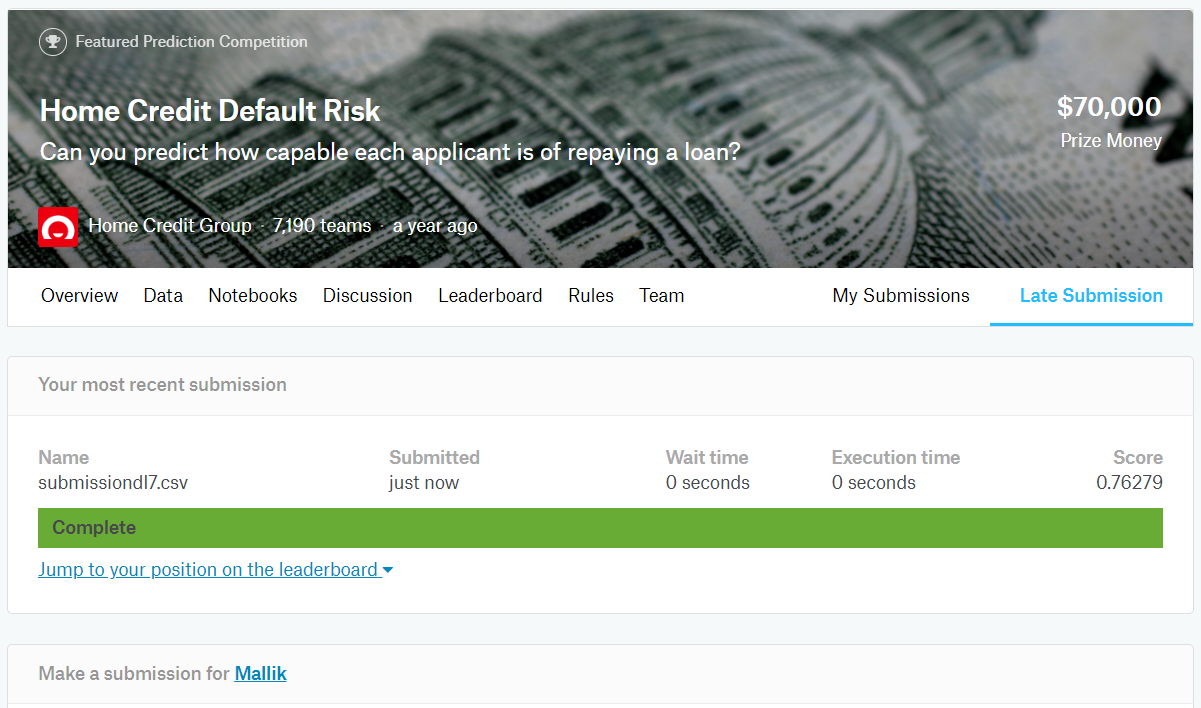

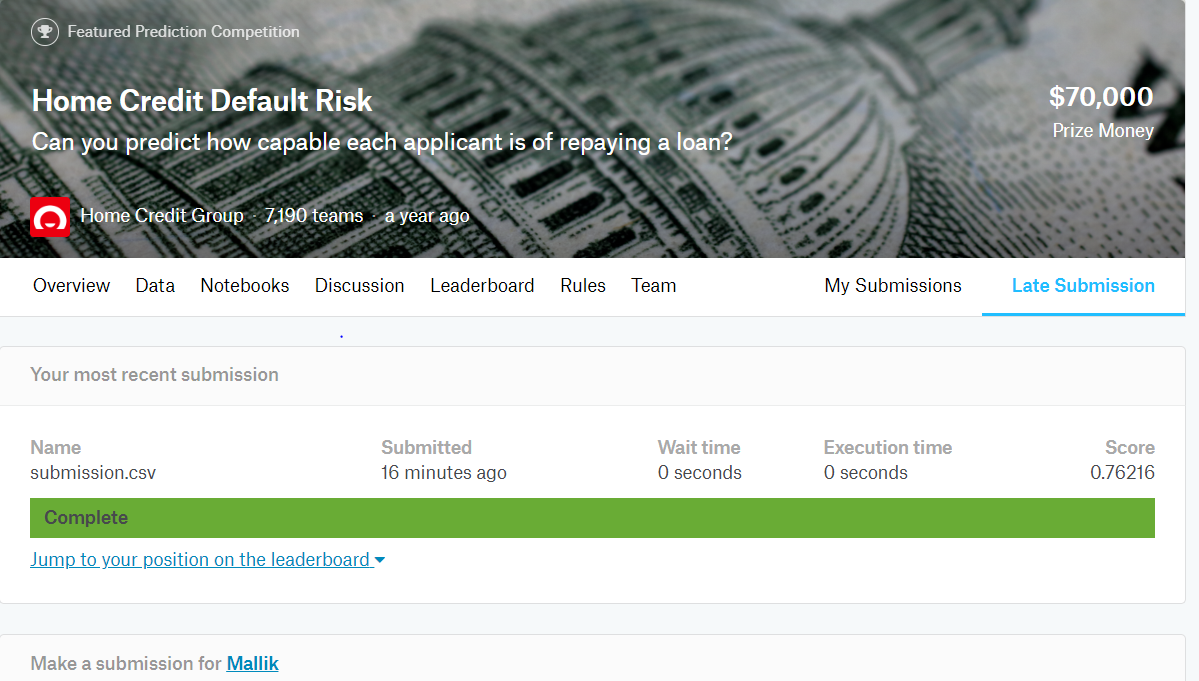

Home Credit Default Risk | Kaggle 2019-11-24 07-30-15.png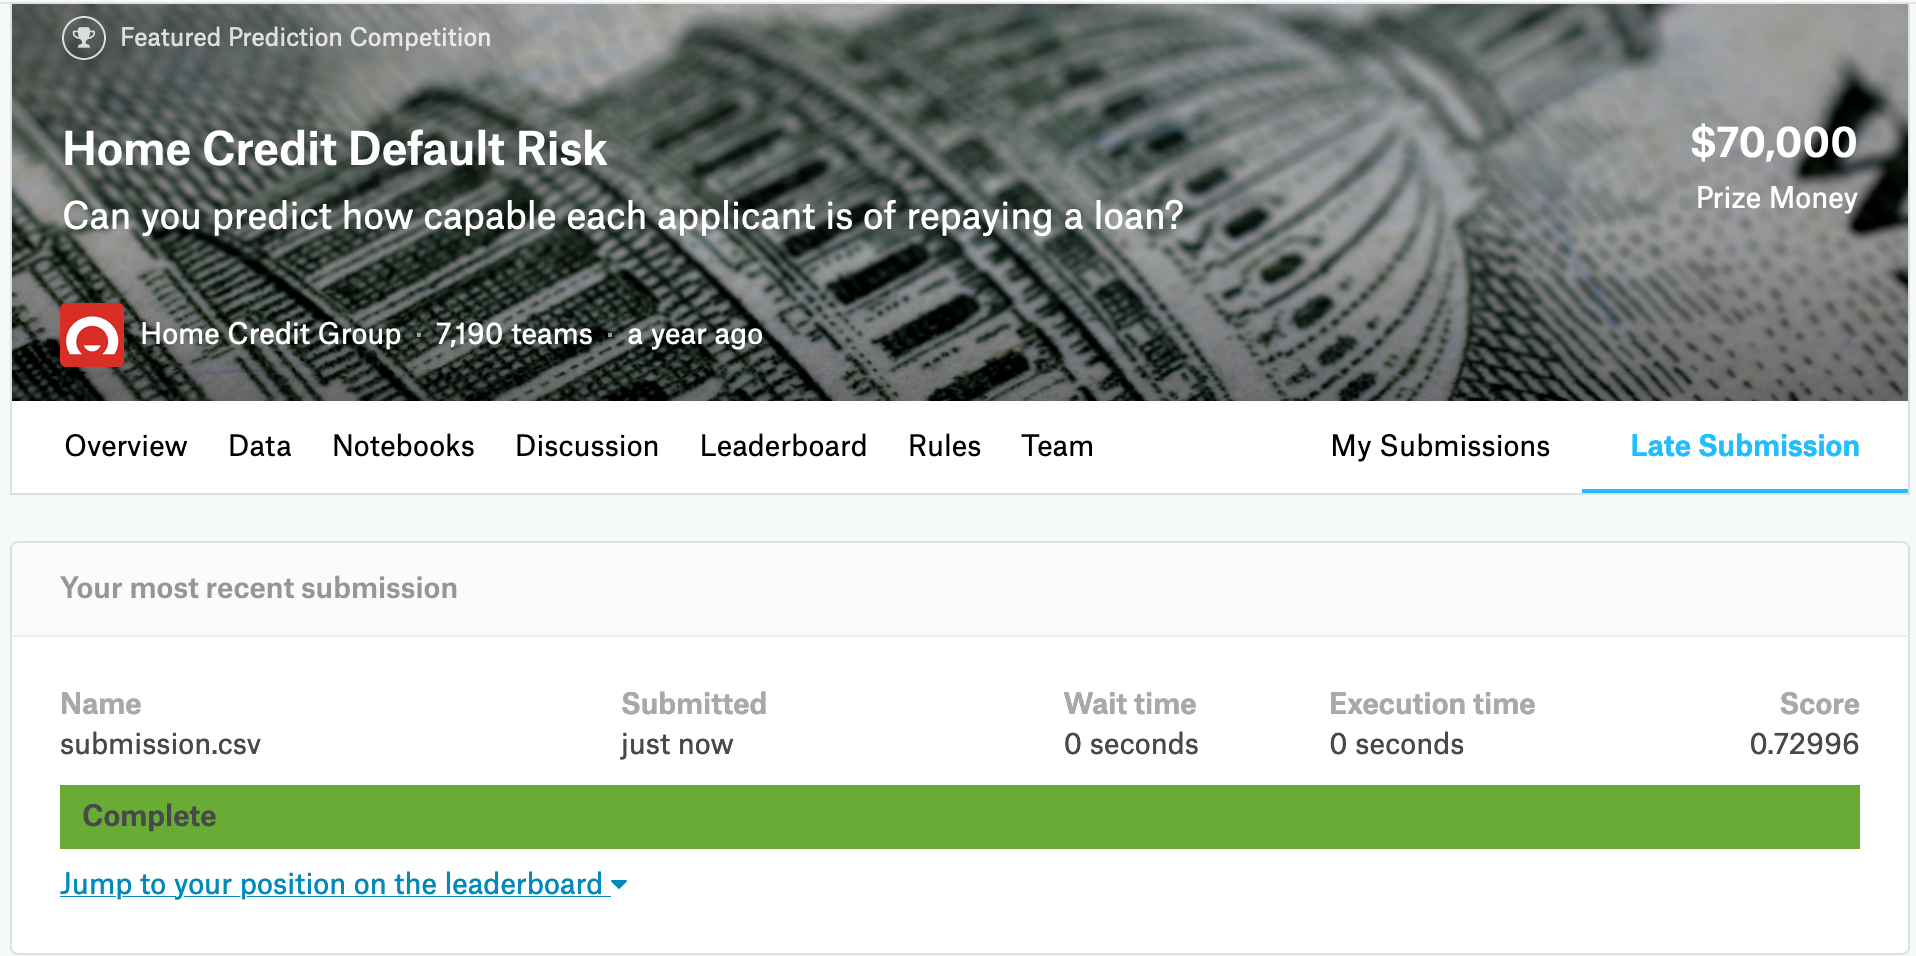


# Write-up 
For this phase of the project, you will need to submit a write-up summarizing the work you did. 
The write-up form is available on Canvas (Modules-> Module 12.1 - Course Project - Home Credit Default Risk (HCDR)-> FP Phase 2 (HCDR) : write-up form ). It has the following sections: 
## Abstract
Please provide an abstract summarizing the work you did (150 words)
## Introduction
## Feature Engineering and transformers
Please explain the work you conducted on feature engineering and transformers. 
Please include code sections when necessary as well as images or any relevant material
## Pipelines
Please explain the pipelines you created for this project and how you used them
Please include code sections when necessary as well as images or any relevant material
## Experimental results
Please present the results of the various experiments that you conducted. The results should be shown in a table or image. Try to include the different details for each experiment.  

Please include code sections when necessary as well as images or any relevant material
## Discussion
Discuss  & analyze your different experimental results  

Please include code sections when necessary as well as images or any relevant material
## Conclusion
## Kaggle Submission
Please provide a screenshot of your best kaggle submission.   
The screenshot should show the different details of the submission and not just the score.

# References

Some of the material in this notebook has been adopted from [here](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/notebook)


In [ ]:
# Convert categorical features to numerical approximations (via pipeline)
class ClaimAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None): 
        charlson_idx_dt = {'0': 0, '1-2': 2, '3-4': 4, '5+': 6}
        los_dt = {'1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6,
          '1- 2 weeks': 11, '2- 4 weeks': 21, '4- 8 weeks': 42, '26+ weeks': 180}
        X['PayDelay'] = X['PayDelay'].apply(lambda x: int(x) if x != '162+' else int(162))
        X['DSFS'] = X['DSFS'].apply(lambda x: None if pd.isnull(x) else int(x[0]) + 1)
        X['CharlsonIndex'] = X['CharlsonIndex'].apply(lambda x: charlson_idx_dt[x])
        X['LengthOfStay'] = X['LengthOfStay'].apply(lambda x: None if pd.isnull(x) else los_dt[x])
        return X
    
    


In [ ]:
# Split the provided training data into training and validationa and test
# The kaggle evaluation test set has no labels
#
from sklearn.model_selection import train_test_split

use_application_data_ONLY = False #use joined data
if use_application_data_ONLY:
    # just selected a few features for a baseline experiment
    selected_features = ['AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
        'EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
                   'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']
    X_train = datasets["application_train"][selected_features]
    y_train = datasets["application_train"]['TARGET']
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
    X_kaggle_test= datasets["application_test"][selected_features]
    # y_test = datasets["application_test"]['TARGET']   #why no  TARGET?!! (hint: kaggle competition)

selected_features = ['AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
        'EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
                   'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']
y_train = X_train['TARGET']
X_train = X_train[selected_features]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_kaggle_test= X_kaggle_test[selected_features]
# y_test = datasets["application_test"]['TARGET']   #why no  TARGET?!! (hint: kaggle competition)

    
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")
print(f"X X_kaggle_test   shape: {X_kaggle_test.shape}")

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import re

# Creates the following date features
# But could do so much more with these features
#    E.g., 
#      extract the domain address of the homepage and OneHotEncode it
# 
# ['release_month','release_day','release_year', 'release_dayofweek','release_quarter']
class prep_OCCUPATION_TYPE(BaseEstimator, TransformerMixin):
    def __init__(self, features="OCCUPATION_TYPE"): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.features)
        #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit         
        df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].apply(lambda x: 1. if x in ['Core Staff', 'Accountants', 'Managers', 'Sales Staff', 'Medicine Staff', 'High Skill Tech Staff', 'Realty Agents', 'IT Staff', 'HR Staff'] else 0.)   
        #df.drop(self.features, axis=1, inplace=True)
        return np.array(df.values)  #return a Numpy Array to observe the pipeline protocol
    

from sklearn.pipeline import make_pipeline 
features = ["OCCUPATION_TYPE"]
def test_driver_prep_OCCUPATION_TYPE():
    print(f"X_train.shape: {X_train.shape}\n")
    print(f"X_train['name'][0:5]: \n{X_train[features][0:5]}")
    test_pipeline = make_pipeline(prep_OCCUPATION_TYPE(features))
    return(test_pipeline.fit_transform(X_train))
          
x = test_driver_prep_OCCUPATION_TYPE()
print(f"Test driver: \n{test_driver_prep_OCCUPATION_TYPE()[0:10, :]}")
print(f"X_train['name'][0:10]: \n{X_train[features][0:10]}")


# QUESTION, should we lower case df['OCCUPATION_TYPE'] as Sales staff != 'Sales Staff'? (hint: YES)
